# Part 2: Customer Segmentation

In [67]:
import pandas as pd
import numpy as np
import math
import json


from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, MinMaxScaler
import seaborn as sns #For Data visualization
import matplotlib.pyplot as plt #Data plotting and visualization
sns.set_palette(sns.color_palette('Set2'))

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

from yellowbrick.cluster import silhouette_visualizer, SilhouetteVisualizer, kelbow_visualizer


import plotly.express as px
%matplotlib inline


In [68]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [69]:
from datetime import datetime
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.cluster import KMeans

In [70]:
#Starbucks color code 

starbucks = ["#fcfdfe","#869b92","#416753","#2f6144" ,  "#224634", "#006241"]
starbucks_1=  ["#006633", "#604c4c", "#eac784", "#f0cddb", "#6B9997"]
starbucks_d = ["#cce6da", "#66b491", "#008248"]
starbucks_s = ["#f0d4dc","#00754a","#84233c","#e44c2c","#a17700","#84233c" ,"#604c4c","#ebcabc","#e44c2c","#562f1e","#f0cdbc"]

In [71]:
#Import functions
from clean_data import clean_portfolio, clean_profile, clean_transcript, plot_data, plot_data_overall, plot_data_sum

In [72]:
#Store clean Portfolio data to portfoio_df
portfolio_df = clean_portfolio(portfolio)

#Store clean Profile data to profile_df
profile_df, profile_m = clean_profile(profile)

#Store clean transcript data to two seperate data frames. 
#Offers_df to store offer data, transactions_df to store transactions data
offers_df,transactions_df  = clean_transcript(transcript)

In [73]:
portfolio_df

,offer_id,offer_name,offer_type,offer_difficulty,offer_duration,offer_reward,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,offer_1,bogo,10,7,10,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,offer_2,bogo,10,5,10,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,offer_3,informational,0,4,0,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_4,bogo,5,7,5,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_5,discount,20,10,5,1,0,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer_6,discount,7,7,3,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,offer_7,discount,10,10,2,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,offer_8,informational,0,3,0,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,offer_9,bogo,5,5,5,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,offer_10,discount,10,7,2,1,1,0,1


In [74]:
profile_df.head(4)

,customer_id,gender,age,age_group,customer_income,customer_income_range,became_member_on,membership_year
0,0610b486422d4921ae7d2bf64640c50b,F,55,GenXers(44-56),112000.0,$100K+,2017-07-15,2017
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,Boomers(57-75),100000.0,$100K+,2017-05-09,2017
2,e2127556f4f64592b11af22de27a7932,M,68,Boomers(57-75),70000.0,"$50,000 - $74,999",2018-04-26,2018
3,389bc3fa690240e798340f5a15918d5c,M,65,Boomers(57-75),53000.0,"$50,000 - $74,999",2018-02-09,2018


In [75]:
profile_m.head(4)

,customer_id,F,M,O,GenZ(18–25),Millennias(26-43),GenXers(44-56),Boomers(57-75),Matures(76+),Under $50K,"$50,000 - $74,999","$75,000 - $99,999",$100K+,2013,2014,2015,2016,2017,2018
0,0610b486422d4921ae7d2bf64640c50b,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
3,389bc3fa690240e798340f5a15918d5c,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1


In [76]:
offers_df.head(4)

,customer_id,event,time_in_days,offer_id,completed,received,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0


In [77]:
transactions_df.head(4)

,customer_id,event,time_in_days,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51


# (A). Customer Segmentation: RFM Analysis 

In this section we are going to perform Recency Frequency Monetary value analysis of the customer. 

RFM Analysis is a very commonly used method in marketing analytics to segments customers into homogeneous groups. The three variables used for RFM analysis are:

* **Recency**: When did the customer make the last purchase?

* **Frequency**: How frequently does the customer make a purchase?

* **Monetary**: How much has the customer spent?

These values can be collected from the customer's transaction data based on information like Date of purchase, money spent for each transactions.


**Steps are as below**:

* Identify most rescent purchase, aggregate total number of purchases, aggregate total amount spent by each customer.
* Compute RFM variables and assign RFM scores.
* Segmenting customers according to scorings.
* Analyze customers falling under each of the segment

In [78]:
#RFM Analysis

In [79]:
#Function to calcuate the most (R)ecent purchase,(F)requecny of purchase, and the (M)onetry sum of total purchase.

def rfm_funct(transactions = transactions_df):
    
    """
    INPUT :
        transactions : transactions_df(processed transctions data)
        
    RETURN :
        rfm_df : updated portfolio df with addtional col of name of each offer ids
        
    """
    
    rfm_df = transactions.groupby('customer_id').agg(
    {'time_in_days': 'max' ,'amount': ['count', 'sum'] }).reset_index(col_level=1)
    
    rfm_df.columns = ['customer_id' , 'time_in_days'  ,'Frequency', 'Monetary']
    
    rfm_df = rfm_df.sort_values(['time_in_days', 'Frequency', 'Monetary'], ascending=False)
    
    rfm_df['Recency']  = rfm_df['time_in_days'].max() - rfm_df['time_in_days']
    
    rfm_df = rfm_df[['customer_id', 'Recency', 'Frequency', 'Monetary']]
    
    return rfm_df


rfm_df = rfm_funct(transactions_df)

### Analyze RFM Dataset before scoring

In [80]:
rfm_df.sample(4)

,customer_id,Recency,Frequency,Monetary
4070,3ec1a7cf9bc348e79ba5c7d6db46100a,16,1,14.38
8991,8a6a2df8be214007991afb612eb64c1c,3,8,22.62
7718,77320a68605841169979f8b497ba0ca1,1,11,334.43
10331,9e1b77408fdb414bb6d36a1aa04567e8,8,8,21.41


In [81]:
#Discriptive analysis
display(rfm_df.describe())

,Recency,Frequency,Monetary
count,16578.000000,16578.000000,16578.000000
mean,3.202015,8.381771,107.096874
std,3.442917,5.009822,126.393939
min,0.000000,1.000000,0.050000
25%,1.000000,5.000000,23.682500
50%,2.000000,7.000000,72.410000
75%,5.000000,11.000000,150.937500
max,29.000000,36.000000,1608.690000


In [82]:

def RFM_DistributionPlot(rfm_df = rfm_df):

    #Recency distribution

    plt.figure(figsize=[5,3])
    rfm_hist1 = sns.histplot(data = rfm_df, x = 'Recency',  multiple = "dodge",element = 'step', 
                            bins = 30, kde = True ,stat = 'count' ).set_title("Recency distribution")
    plt.xlabel("Recency")
    plt.ylabel("Customer count")


    #Frequency distribution

    plt.figure(figsize=[5,3])
    rfm_hist1 = sns.histplot(data = rfm_df, x = 'Frequency',  multiple = "dodge",element = 'step', 
                            bins = 20, kde = True ,stat = 'count' ).set_title("Frequency distribution")
    plt.xlabel("Frequency")
    plt.ylabel("Customer count")


    #Monetary distribution

    plt.figure(figsize=[5,3])
    rfm_hist1 = sns.histplot(data = rfm_df, x = 'Monetary',  multiple = "dodge",element = 'step', 
                            bins = 100, kde = True ,stat = 'count' ).set_title("Spend distribution")
    plt.xlabel("Monetary(USD)")
    plt.ylabel("Customer count")
    
    return rfm_hist1

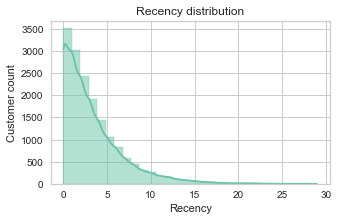

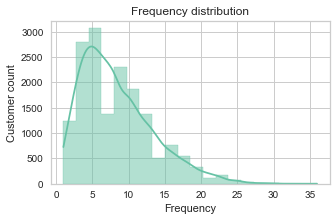

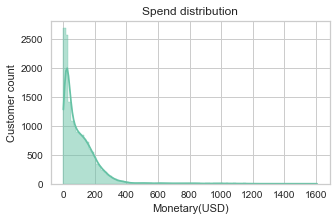

In [83]:
#RFM distribution

rfm_dist = RFM_DistributionPlot(rfm_df)

Based on the above graphs we can see that the Recency, Frequency and Monetary values are right-Skewed. 

* Recency mean value: ~ 3 days.
* Frequency mean value: ~ 8 purchases.
* Monetary mean value: USD 107

In [84]:
#Since the recency, frequency and monetary data is highly skewed to right. We perform normalization 
scaler = MinMaxScaler()
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']]))
rfm_normalized.columns = ['Recency', 'Frequency', 'Monetary']

In [85]:
from sklearn import preprocessing
d = preprocessing.normalize(rfm_df[['Recency', 'Frequency', 'Monetary']], axis=0)
scaled_df = pd.DataFrame(d, columns=['Recency', 'Frequency', 'Monetary'])

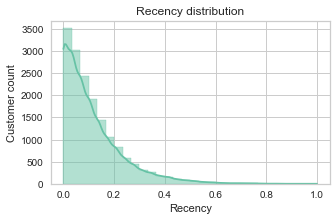

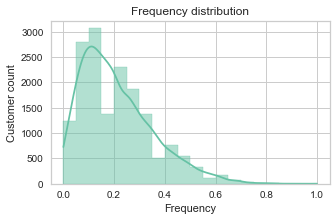

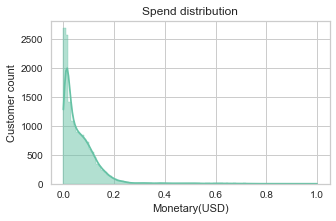

In [86]:
rfm_n_dist_test = RFM_DistributionPlot(rfm_normalized)

In [87]:
rfm_normalized.head(5)

,Recency,Frequency,Monetary
0,0.0,1.000000,0.107768
1,0.0,0.971429,0.056060
2,0.0,0.857143,0.286602
3,0.0,0.828571,0.445818
4,0.0,0.828571,0.162025


Text(0.5, 1.0, 'Correlation Heatmap')

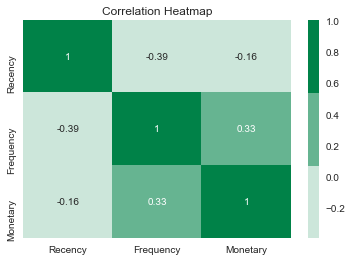

In [88]:
#Correlation between Recency, Frequency and monetary values
starbucks = ["#008248", "#604c4c", "#eac784", "#f0cddb", "#6B9997"]
sns.heatmap(rfm_normalized.iloc[:,0:4].corr() , annot=True, cmap =starbucks_d )
plt.title('Correlation Heatmap')

We can observe:

* Correlation between Frequency and the Monetary value. 
* Negatve correlation between Recency and Monetary



## I. Modeling

### Computation of RFM

Here we are going to determing how to compute the Recency, Frequency and Monetary data values. 

Ther are few approcahes to do this. Here we are going to check two such approches and check which shows the best results. 

The two approaches that we are going to check are:

#### Method 1: 
Compute the RFM codes by using K-Means clusteing algorithm. 

#### Method 2: 
Sort customers based on R, F, M values and then combine into RFM codes using traditional method,then use K-means clustering to determine cluster. 



### Method1: Compute the RFM codes by using K-Means clusteing algorithm.

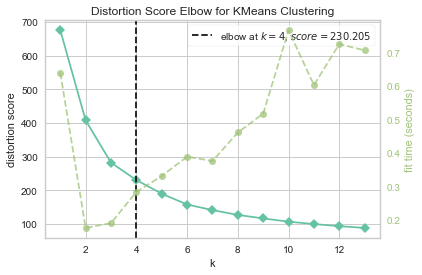

In [89]:
#Use elbow method to determine the optimum number of clusters needed for Method1

kelbow_visualizer(KMeans(), rfm_normalized, k=(1,14));

The WCSS value starts slowing down after the 4th cluster. 'Elbow' at k=4, thus the optimal number of cluster is 4. 

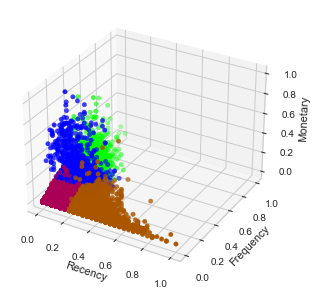

In [90]:
#Visualize the clusters in a 3-d scatter plot

kmeans = KMeans(n_clusters = 4,init = 'k-means++', random_state = 42)
kmeans.fit(rfm_normalized)
centers = kmeans.cluster_centers_

sns.set_palette(sns.color_palette('Set2'))

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(rfm_normalized['Recency'],rfm_normalized['Frequency'],rfm_normalized['Monetary'], 
           cmap = 'brg', c=kmeans.predict(rfm_normalized))


ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

ax.scatter(centers[:,0], centers[:,1], c='black')

C:\Users\Arjun Achuthan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


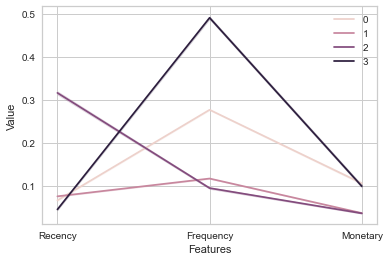

In [91]:
rfm_method1 = rfm_normalized.copy()#pd.DataFrame(scaler.inverse_transform(rfm_normalized))
#rfm_plot2.columns = rfm_df[['Recency', 'Frequency', 'Monetary']].columns
rfm_method1['Index_a'] = rfm_df.index
rfm_method1['cluster'] = kmeans.labels_

melted_rfm_normalized = pd.melt(rfm_method1.reset_index(), id_vars=['Index_a','cluster'],
                                value_vars = ['Recency', 'Frequency', 'Monetary'],
                                var_name = 'Features', value_name = 'Value')

sns.lineplot('Features', 'Value', hue = 'cluster', data = melted_rfm_normalized)
plt.legend()

In [92]:
rfm_df_method1 = rfm_df.copy()

rfm_df_method1['rfm_cluster']= rfm_method1['cluster'].copy()
rfm_df_method1.head(5)

,customer_id,Recency,Frequency,Monetary,rfm_cluster
7887,79d9d4f86aca4bed9290350fb43817c2,0,36,173.41,1
9702,94de646f7b6041228ca7dec82adb97d2,0,35,90.23,0
10740,a42ed50acc4d4b25bca647c9e0b916ad,0,31,461.09,1
11192,ab25fd6fbd5040f880751921e4029757,0,30,717.21,0
13558,d0a80415b84c4df4908b8403b19765e3,0,30,260.69,0


In [93]:
rfm_df_method1.groupby('rfm_cluster').agg({
    'Recency': ['count','mean', 'median','min','max'],
    'Frequency': ['count','mean', 'median','min', 'max'],
    'Monetary': ['count','mean', 'median','min', 'max']
})

Recency                          Frequency                       \
              count      mean median min max     count      mean median min   
rfm_cluster                                                                   
0              5367  3.200671      2   0  29      5367  8.325694      7   1   
1              6308  3.235098      2   0  27      6308  8.381579      7   1   
2              2867  3.193931      2   0  27      2867  8.493198      8   1   
3              2036  3.114440      2   0  22      2036  8.373281      7   1   

                Monetary                                     
            max    count        mean  median   min      max  
rfm_cluster                                                  
0            36     5367  106.726844  72.110  0.05  1327.74  
1            36     6308  106.098031  71.865  0.05  1321.42  
2            29     2867  110.575145  75.960  0.05  1365.66  
3            29     2036  106.268998  71.015  0.10  1608.69

In [94]:
starbucks_r = ["#00704A","#84233c" ,"#ebcabc","#604c4c","#ebcabc","#a17700","#e44c2c","#562f1e","#f0cdbc"]

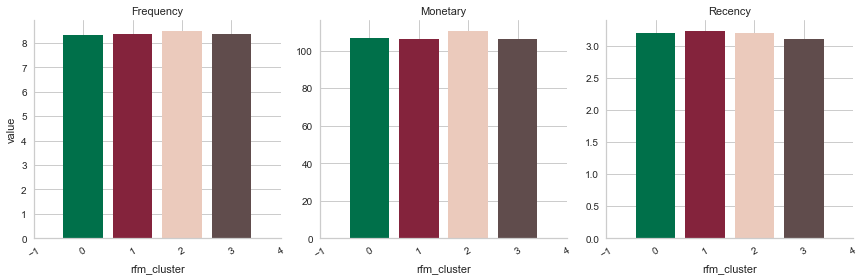

In [95]:
#Visualize the mean Frequency, Monetary, and Recency value across each clusters. 

rfm_da= rfm_df_method1[['customer_id','Recency','Frequency','Monetary']]
df = plot_data(rfm_da,rfm_df_method1,  groupby = 'rfm_cluster',palette =starbucks_r,col_wrap=5,height=4,label_rotation =30)

### Method 2: 
#### Using RFM ranking and then dividing the segments using K-means clustering of the ranked variabes. 

In [96]:
#Method 2:

#Assign recency variables to four equal quartile groups
r_labels = range(4,0,-1)
r_groups = pd.qcut(rfm_df['Recency'], q=4, labels= r_labels)
rfm_df['r_score'] = pd.DataFrame(r_groups)

#Assign recency variables to four equal quartile groups
f_labels = range(1,5)
f_groups = pd.qcut(rfm_df['Frequency'], q=4, labels= f_labels)
rfm_df['f_score'] = pd.DataFrame(f_groups)

#Assign recency variables to four equal quartile groups
m_labels = range(1,5)
m_groups = pd.qcut(rfm_df['Monetary'], q=4, labels= m_labels)
rfm_df['m_score'] = pd.DataFrame(m_groups)



In [97]:
rfm_df.head()

,customer_id,Recency,Frequency,Monetary,r_score,f_score,m_score
7887,79d9d4f86aca4bed9290350fb43817c2,0,36,173.41,4,4,4
9702,94de646f7b6041228ca7dec82adb97d2,0,35,90.23,4,4,3
10740,a42ed50acc4d4b25bca647c9e0b916ad,0,31,461.09,4,4,4
11192,ab25fd6fbd5040f880751921e4029757,0,30,717.21,4,4,4
13558,d0a80415b84c4df4908b8403b19765e3,0,30,260.69,4,4,4


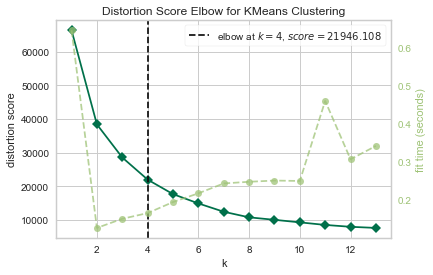

In [98]:
#Use elbow method to determine the optimum number of clusters needed for Method2
kelbow_visualizer(KMeans(), rfm_df.iloc[:,4:7], k=(1,14));

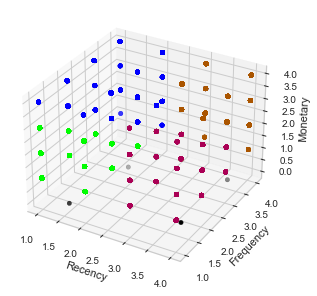

In [99]:
kmeans1 = KMeans(n_clusters = 4,init = 'k-means++', random_state = 42)
kmeans1.fit(rfm_df.iloc[:,4:7])
centers = kmeans1.cluster_centers_

fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(rfm_df['r_score'],rfm_df['f_score'],rfm_df['m_score'], 
           cmap = 'brg', c=kmeans1.predict(rfm_df.iloc[:,4:7]))

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

ax.scatter(centers[:,0], centers[:,1], c='black')

In [100]:
rfm_method2 = rfm_df.iloc[:,4:7] #pd.DataFrame(scaler.inverse_transform(rfm_normalized))
rfm_method2.columns = rfm_method2[['r_score', 'f_score', 'm_score']].columns
rfm_method2['index_a'] = rfm_df.index
rfm_method2['rfm_cluster'] = kmeans1.labels_

C:\Users\Arjun Achuthan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


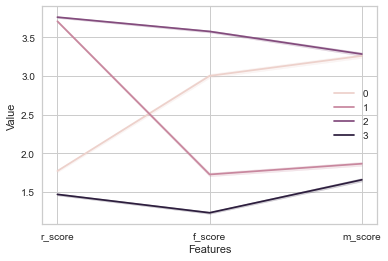

In [101]:
melted_rfm = pd.melt( rfm_method2, id_vars=['index_a','rfm_cluster'],
                                value_vars = ['r_score', 'f_score', 'm_score'],
                                var_name = 'Features', value_name = 'Value')

sns.lineplot('Features', 'Value', hue = 'rfm_cluster', data = melted_rfm)
plt.legend()

In [102]:
rfm_df['rfm_segment']= rfm_method2['rfm_cluster'].copy()
rfm_df['rfm_cluster'] = rfm_method2['rfm_cluster'].copy()
rfm_df['rfm_segment'] = rfm_df['rfm_segment'].replace([0,1,2,3], ['High value/High risk','New Customer',
                                                                  'Best Customer','Low Value Customer'])

In [103]:
rfm_df.groupby('rfm_segment').agg({
    'Recency': ['count','mean', 'median','min','max'],
    'Frequency': ['count','mean', 'median','min', 'max'],
    'Monetary': ['count','mean', 'median','min', 'max']
})

Recency                          Frequency             \
                       count      mean median min max     count       mean   
rfm_segment                                                                  
Best Customer           4871  0.814822      1   0   2      4871  13.282899   
High value/High risk    3243  4.637064      4   2  18      3243  10.134135   
Low Value Customer      4456  6.807899      6   3  29      4456   4.082361   
New Customer            4008  0.933134      1   0   2      4008   5.787425   

                                    Monetary                              \
                     median min max    count        mean   median    min   
rfm_segment                                                                
Best Customer            13   6  36     4871  175.729388  157.270  12.91   
High value/High risk      9   2  29     3243  166.951230  145.970  14.43   
Low Value Customer        4   1  11     4456   38.623153   21.425   0.05   
New Customer              6   1  11     4008   51.383860   29.200   0.05   

                               
                          max  
rfm_segment                    
Best Customer         1608.69  
High value/High risk  1327.74  
Low Value Customer     150.63  
New Customer          1153.11

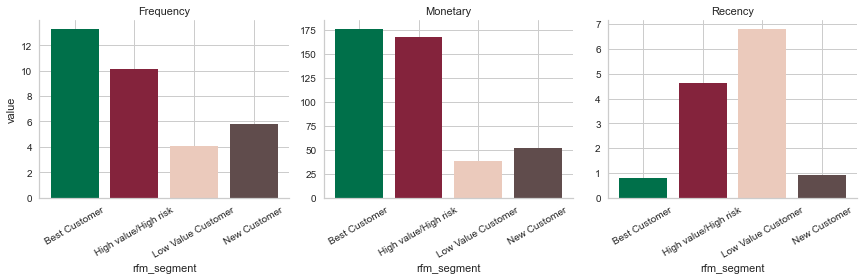

In [104]:
#Visualize the mean Frequency, Monetary, and Recency value across each RFM segments

rfm_da= rfm_df[['customer_id','Recency','Frequency','Monetary']]
df = plot_data(rfm_da,rfm_df,  groupby = 'rfm_segment',palette =starbucks_r,col_wrap=5,height=4,label_rotation =30)

## II. Model Evaluationa and Validation

##### Analysis: Comparing Method 1 and Method 2


**Method 1:** We see that all segments seem to have very less variation the mean Recency, frequency and Monetary values. Thus not helpful in developing insights. 

**Method 2:** We see each clusters have distinct mean values, thus we can clearly identif distinct customer segments namely

* Cluster 0: **High value with high risk of leaving** -  Low Recency , High Frequency and High Monetary.
* Cluster 1: **New Customer**                        - High Recency, Low Frequency and Low Monetary. 
* Cluster 2: **Best Customer**                       - High Recency , High Frequency and High Monetary.
* Cluster 3: **Low value customer**                  - Low Recency, Low Frequency and Low Monetary.


Comparing the results from Method 1 and Method 2, we can clearly see that we get a far better by clustering the RFM scores rather than using the raw recency,frequency and Monetary values. 


## III. Visualization & Presentation

In [105]:
#Import the profile_offer data from data engineering note

profile_offer = pd.read_pickle('profile_offer.pkl')
profile_offer

,customer_id,gender,age,age_group,customer_income,customer_income_range,became_member_on,membership_year,F,M,...,social_received_count,social_viewed_count,social_completed_count,social_viewed_rate,social_completed_rate,web_received_count,web_viewed_count,web_completed_count,web_viewed_rate,web_completed_rate
0,0610b486422d4921ae7d2bf64640c50b,F,55,GenXers(44-56),112000.0,$100K+,2017-07-15,2017,1,0,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.000000
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,Boomers(57-75),100000.0,$100K+,2017-05-09,2017,1,0,...,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.000000
2,e2127556f4f64592b11af22de27a7932,M,68,Boomers(57-75),70000.0,"$(50,000-74,999)",2018-04-26,2018,0,1,...,1.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,1.0,0.666667
3,389bc3fa690240e798340f5a15918d5c,M,65,Boomers(57-75),53000.0,"$(50,000-74,999)",2018-02-09,2018,0,1,...,3.0,3.0,3.0,1.0,1.0,6.0,6.0,5.0,1.0,0.833333
4,2eeac8d8feae4a8cad5a6af0499a211d,M,58,Boomers(57-75),51000.0,"$(50,000-74,999)",2017-11-11,2017,0,1,...,2.0,2.0,1.0,1.0,0.5,2.0,2.0,1.0,1.0,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14759,6d5f3a774f3d4714ab0c092238f3a1d7,F,45,GenXers(44-56),54000.0,"$(50,000-74,999)",2018-06-04,2018,1,0,...,2.0,2.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,0.000000
14760,2cb4f97358b841b9a9773a7aa05a9d77,M,61,Boomers(57-75),72000.0,"$(50,000-74,999)",2018-07-13,2018,0,1,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.000000
14761,01d26f638c274aa0b965d24cefe3183f,M,49,GenXers(44-56),73000.0,"$(50,000-74,999)",2017-01-26,2017,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14762,9dc1421481194dcd9400aec7c9ae6366,F,83,Matures(76+),50000.0,"$(50,000-74,999)",2016-03-07,2016,1,0,...,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.000000


In [106]:
#Merge the RFM data to the profile_offer DataFrame

rfm_analysis = pd.merge(profile_offer, rfm_df, left_on='customer_id', right_on='customer_id', how='inner')

In [107]:
#Create dummy variables for the RFM segments
rfm_dummies = pd.get_dummies(rfm_analysis['rfm_segment'])
rfm_analysis = rfm_analysis.join(rfm_dummies)

In [108]:
def plot_data_sum(df,demo,groupby,palette,col_wrap,height,label_rotation):
    
    """
    This procedue is used to create aggregate measures per demographic group, and then plot those measures in rplot
    
    
    INPUT: 
    
    -Data input
    --df: input profile_offer dataframe with the measures to be aggrigated. 
    --demo: input profile_offer dataframe
    --groupby: input the domographic group you want to aggrigate for
    
    -Variables for Data visualization
    --palette: Input the No of color palatte for the bar plot
    --col_wrap: Input th enumber of column in the grid
    --height: Input the height of the plot
    --label_rotation: Input degrees to which X-axis labels need to be rotated.

    
    OUTPUT:
    - df: return dataframe with the aggregated measures and the plot
    
    """       
    
    #Aggrigate measure(sum) grouped by demographics 
    
    df = df.join(demo[groupby])
    df = df.copy().reset_index()
    df = df.melt(id_vars=['customer_id', groupby],ignore_index = True)
    df = df.groupby([groupby, 'variable']).sum().reset_index()
    df = df[df['variable']!='index']
    
    #Official Starbucks color palatte
    starbucks = ["#008248", "#604c4c", "#eac784", "#f0cddb", "#6B9997"]
    sns.set_palette(sns.color_palette(starbucks,palette))
    
    #Plot and visualize data in a grid
    g = sns.FacetGrid(df, col='variable', hue= 'variable', col_wrap=col_wrap, height=height, sharey=False)
    g = g.map(plt.bar, groupby, 'value').set_titles("{col_name}")
    g.set_xticklabels(rotation = label_rotation)
    g.tight_layout()
    
    #Return aggregate data
    return df

### 1.  RFM: Demographics analysis

In [109]:
rfm_segment= rfm_analysis[['customer_id','High value/High risk','New Customer','Best Customer','Low Value Customer']]

In [110]:
def plot_data_sum(df,demo,groupby,palette,col_wrap,height,label_rotation):
    
    """
    This procedue is used to create aggregate measures per demographic group, and then plot those measures in rplot
    
    
    INPUT: 
    
    -Data input
    --df: input profile_offer dataframe with the measures to be aggrigated. 
    --demo: input profile_offer dataframe
    --groupby: input the domographic group you want to aggrigate for
    
    -Variables for Data visualization
    --palette: Input the No of color palatte for the bar plot
    --col_wrap: Input th enumber of column in the grid
    --height: Input the height of the plot
    --label_rotation: Input degrees to which X-axis labels need to be rotated.

    
    OUTPUT:
    - df: return dataframe with the aggregated measures and the plot
    
    """       
    
    #Aggrigate measure(sum) grouped by demographics 
    
    df = df.join(demo[groupby])
    df = df.copy().reset_index()
    df = df.melt(id_vars=['customer_id', groupby],ignore_index = True)
    df = df.groupby([groupby, 'variable']).sum().reset_index()
    df = df[df['variable']!='index']
    
    #Official Starbucks color palatte
    sns.set_palette(sns.color_palette(palette))
    
    #Plot and visualize data in a grid
    g = sns.FacetGrid(df, col='variable', hue= 'variable', col_wrap=col_wrap, height=height, sharey=False)
    g = g.map(plt.bar, groupby, 'value').set_titles("{col_name}")
    g.set_xticklabels(rotation = label_rotation)
    g.tight_layout()
    
    #Return aggregate data
    return df

#### 1. Gender:

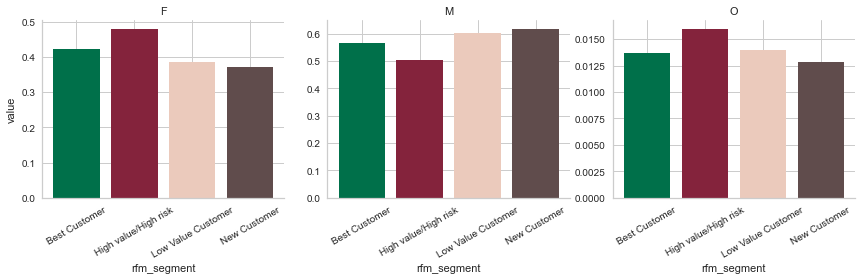

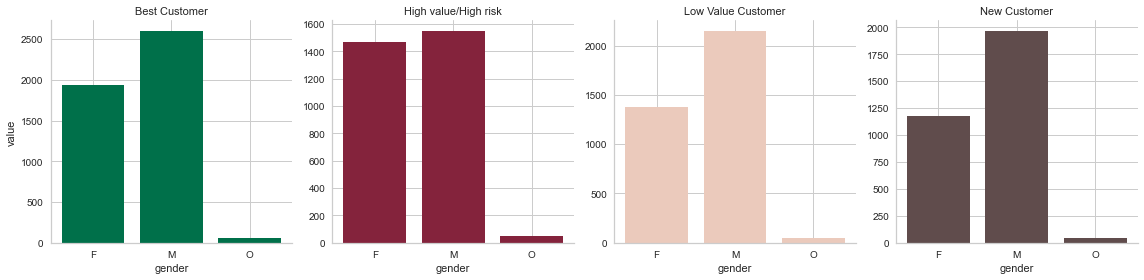

In [111]:
rfm_gender = rfm_analysis[['customer_id','M','F',"O"]]
df = plot_data(rfm_gender,rfm_analysis,  groupby = 'rfm_segment',palette =starbucks_r,col_wrap=5,height=4,label_rotation =30)
df = plot_data_sum(rfm_segment,rfm_analysis,  groupby = 'gender',palette =starbucks_r,col_wrap=4,height=4,label_rotation =0)

#### 2. Age:

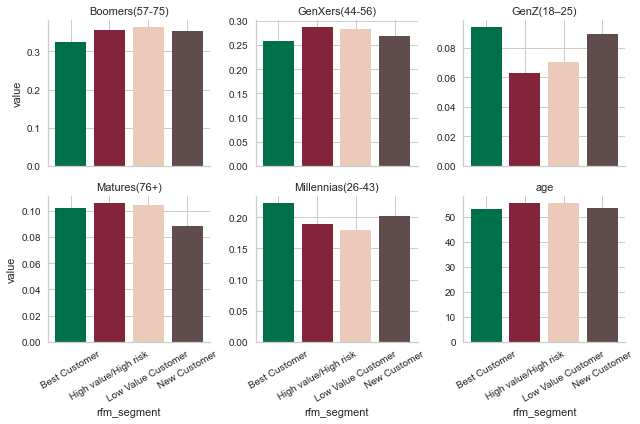

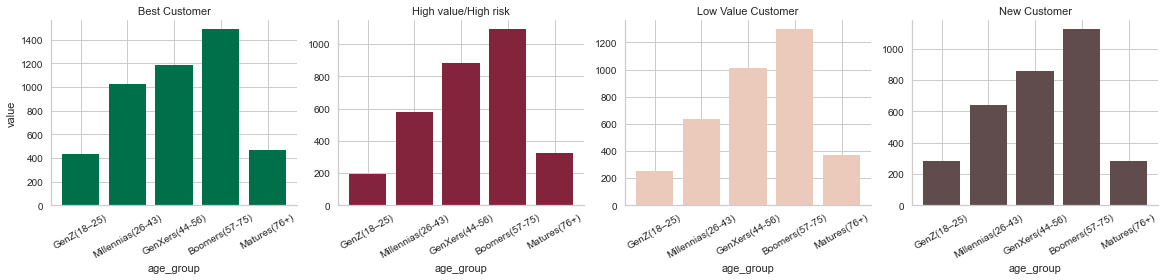

In [112]:
rfm_age= rfm_analysis[['customer_id', 'age','GenZ(18–25)','Millennias(26-43)','GenXers(44-56)','Boomers(57-75)','Matures(76+)']]
df = plot_data(rfm_age,rfm_analysis,  groupby = 'rfm_segment',palette =starbucks_r,col_wrap=3,height=3,label_rotation =30)
df = plot_data_sum(rfm_segment,rfm_analysis,  groupby = 'age_group',palette =starbucks_r,col_wrap=25,height=4,label_rotation =30)

#### 3. Salary

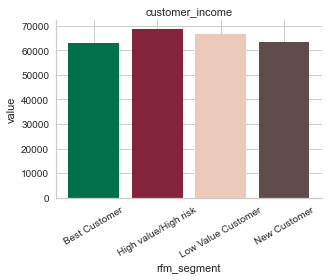

In [113]:
rfm_income = rfm_analysis[['customer_id',"customer_income"]]
df = plot_data(rfm_income,rfm_analysis,  groupby = 'rfm_segment',palette =starbucks_r,col_wrap=5,height=4,label_rotation =30)

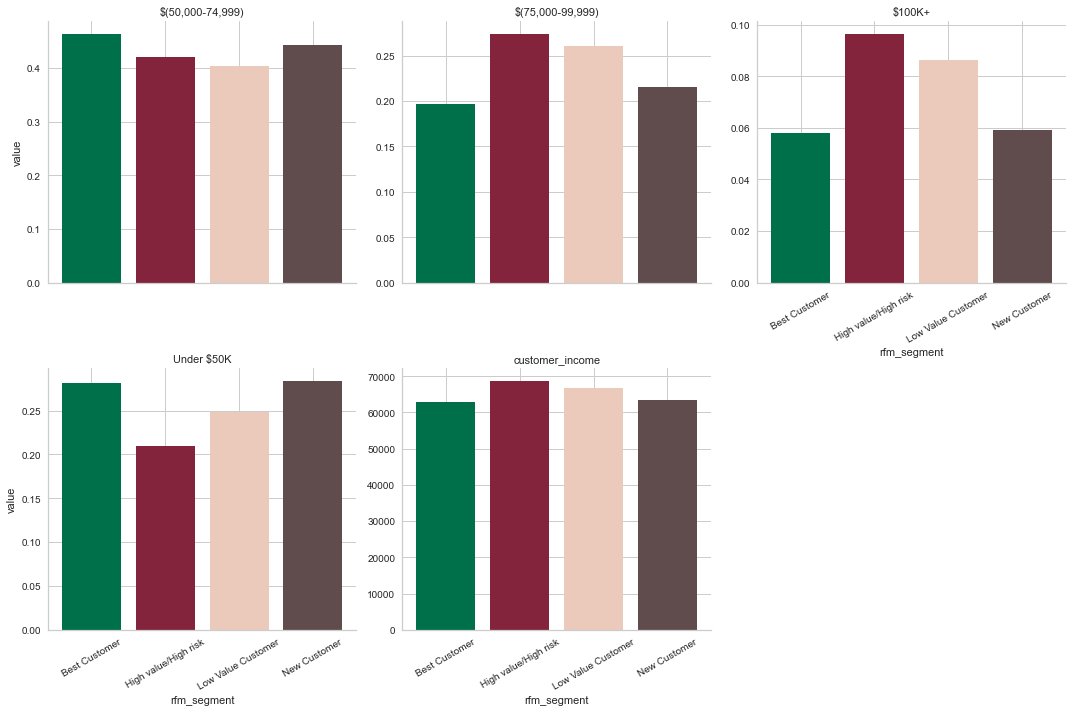

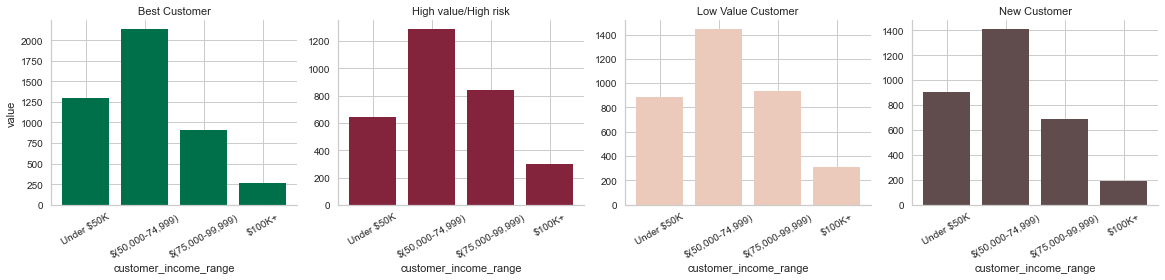

In [114]:
rfm_income_range = rfm_analysis[['customer_id','customer_income', 'Under $50K','$(50,000-74,999)','$(75,000-99,999)', '$100K+']]
df = plot_data(rfm_income_range,rfm_analysis,  groupby = 'rfm_segment',palette =starbucks_r,col_wrap=3,height=5,label_rotation =30)
df = plot_data_sum(rfm_segment,rfm_analysis,  groupby = 'customer_income_range',palette =starbucks_r,col_wrap=25,height=4,label_rotation =30)

#### 4. Year Joined.

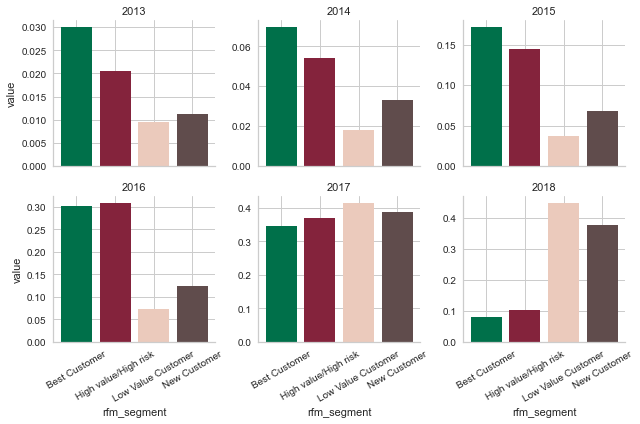

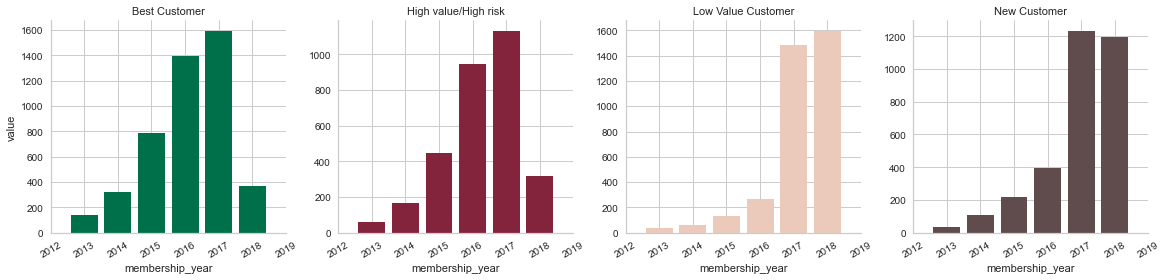

In [115]:
rfm_year = rfm_analysis[['customer_id',2013, 2014, 2015, 2016, 2017, 2018]]
df = plot_data(rfm_year,rfm_analysis,  groupby = 'rfm_segment',palette =starbucks_r,col_wrap=3,height=3,label_rotation =30)
df = plot_data_sum(rfm_segment,rfm_analysis,  groupby = 'membership_year',palette =starbucks_r,col_wrap=25,height=4,label_rotation =30)



### 2. RFM: Offer Analysis:



### (a): Offers

#### 1. Overall Offer performance

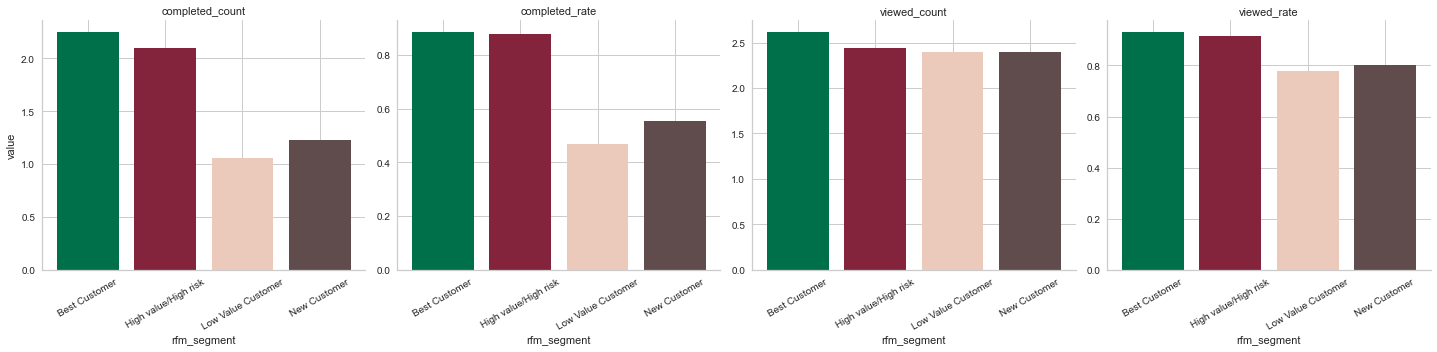

In [116]:
offer_overall = rfm_analysis[['customer_id','viewed_count','completed_count','viewed_rate','completed_rate']]
df = plot_data(offer_overall,rfm_analysis,  groupby = 'rfm_segment',palette =starbucks_r,col_wrap=5,height=5,label_rotation =30)

#### 2. Offer type: BOGO

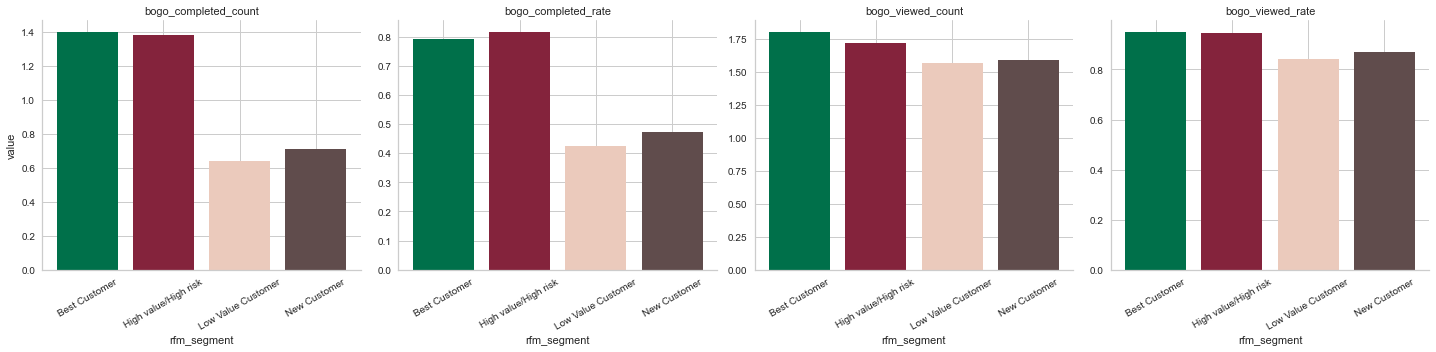

In [117]:
offer_bogo = rfm_analysis[['customer_id','bogo_viewed_count','bogo_completed_count','bogo_viewed_rate','bogo_completed_rate']]
df = plot_data(offer_bogo,rfm_analysis,  groupby = 'rfm_segment',palette =starbucks_r,col_wrap=5,height=5,label_rotation =30)

#### 3. Offer type: Discount

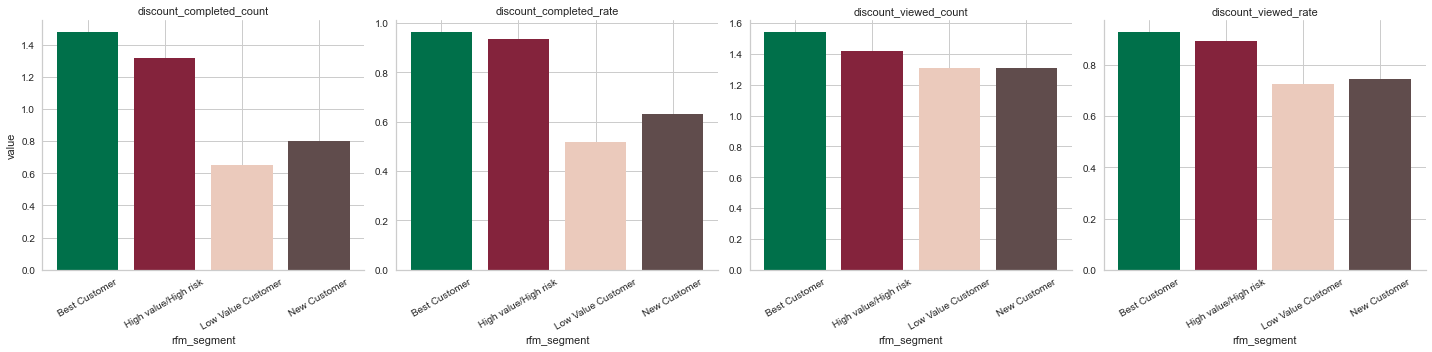

In [118]:
offer_discount = rfm_analysis[['customer_id','discount_viewed_count','discount_completed_count','discount_viewed_rate','discount_completed_rate']]
df = plot_data( offer_discount,rfm_analysis,  groupby = 'rfm_segment',palette =starbucks_r,col_wrap=4,height=5,label_rotation =30)

#### 4. Offer type: Informational

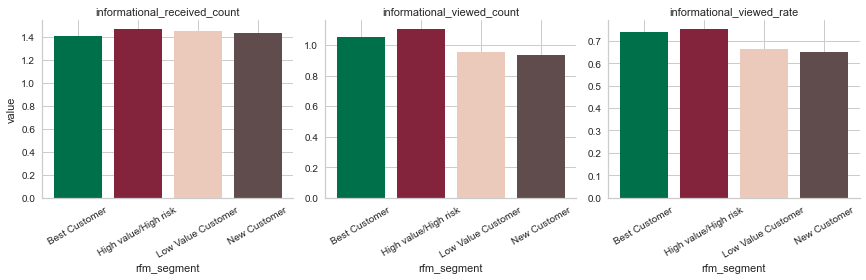

In [119]:
offer_informational = rfm_analysis[['customer_id','informational_received_count','informational_viewed_count','informational_viewed_rate']]
df = plot_data(offer_informational,rfm_analysis,  groupby = 'rfm_segment',palette =starbucks_r,col_wrap=5,height=4,label_rotation =30)

#### (b). Offer Difficulty

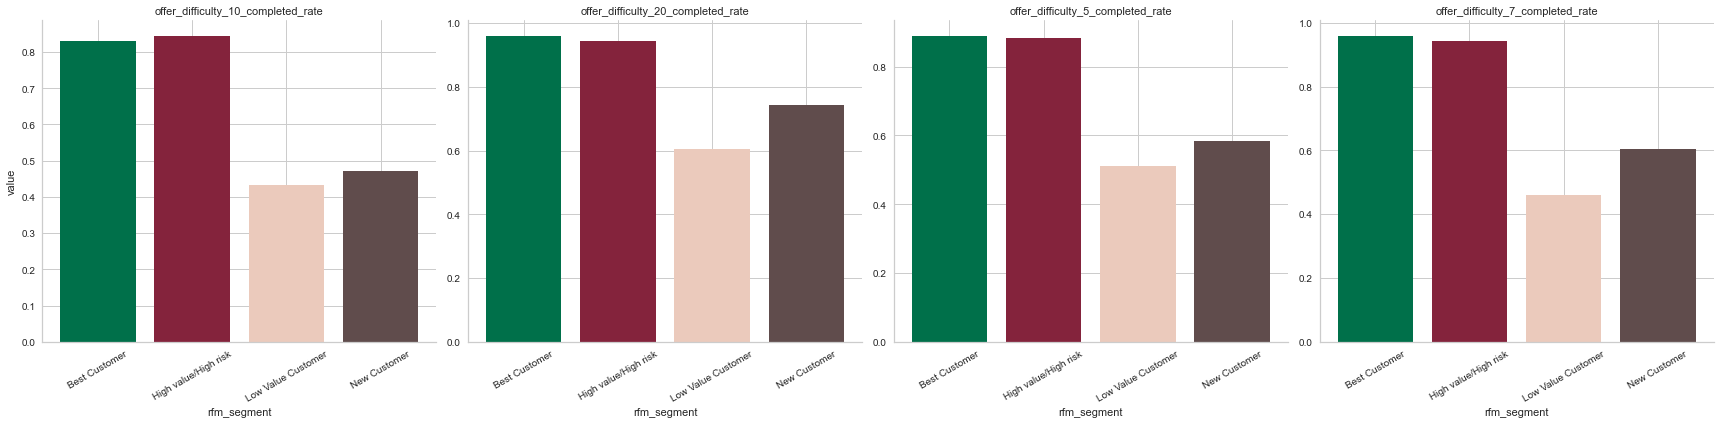

In [120]:
offer_difficulty =  rfm_analysis[['customer_id','offer_difficulty_5_completed_rate',
 'offer_difficulty_20_completed_rate','offer_difficulty_10_completed_rate', 'offer_difficulty_7_completed_rate']]
df = plot_data(offer_difficulty ,rfm_analysis,   groupby = 'rfm_segment',palette =starbucks_r,col_wrap=4,height=6,label_rotation =30)

<AxesSubplot:>

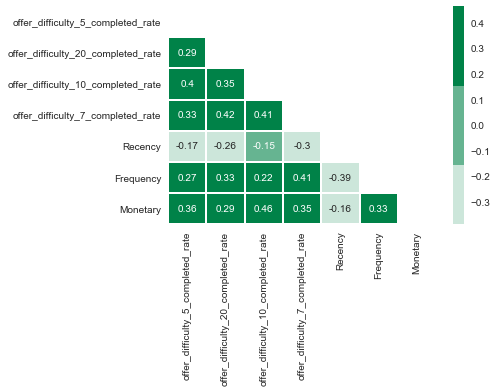

In [121]:
offer_difficulty =  rfm_analysis[['customer_id','offer_difficulty_5_completed_rate',
 'offer_difficulty_20_completed_rate','offer_difficulty_10_completed_rate', 'offer_difficulty_7_completed_rate','Recency','Frequency','Monetary']]
sns.heatmap(offer_difficulty.corr(), annot=True, mask = np.triu(offer_difficulty.corr()), linewidths=1, 
                 center=0, cmap = starbucks_d)

### (c). Offer Duration

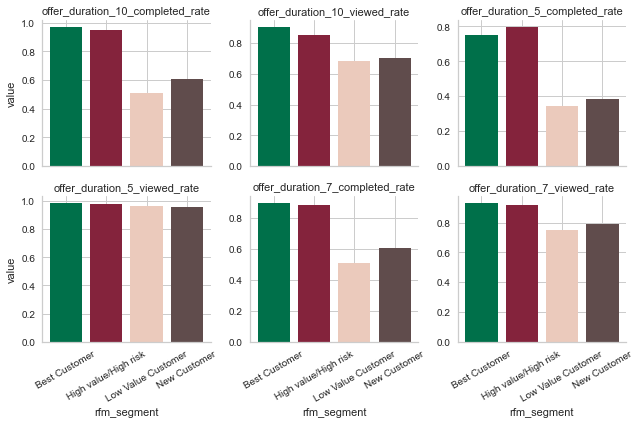

In [122]:
offer_duration =  rfm_analysis[['customer_id', 'offer_duration_7_viewed_rate', 'offer_duration_7_completed_rate',
 'offer_duration_10_viewed_rate', 'offer_duration_10_completed_rate','offer_duration_5_viewed_rate',
 'offer_duration_5_completed_rate']]
df = plot_data(offer_duration ,rfm_analysis,  groupby = 'rfm_segment',palette =starbucks_r,col_wrap=3,height=3,label_rotation =30)

<AxesSubplot:>

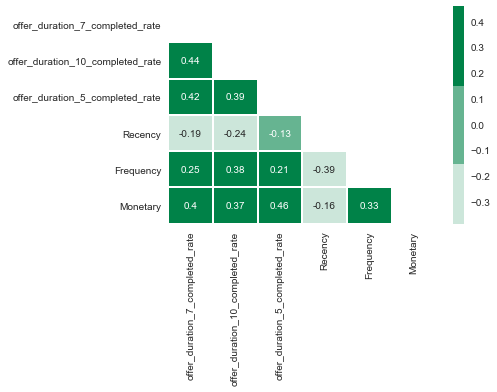

In [123]:
offer_duration = rfm_analysis[['customer_id', 'offer_duration_7_completed_rate','offer_duration_10_completed_rate', 
                               'offer_duration_5_completed_rate','Recency','Frequency','Monetary']]
sns.heatmap(offer_duration.corr(), annot=True, mask = np.triu(offer_duration.corr()), linewidths=1, 
                 center=0, cmap = starbucks_d)

#### (d). Offer Reward

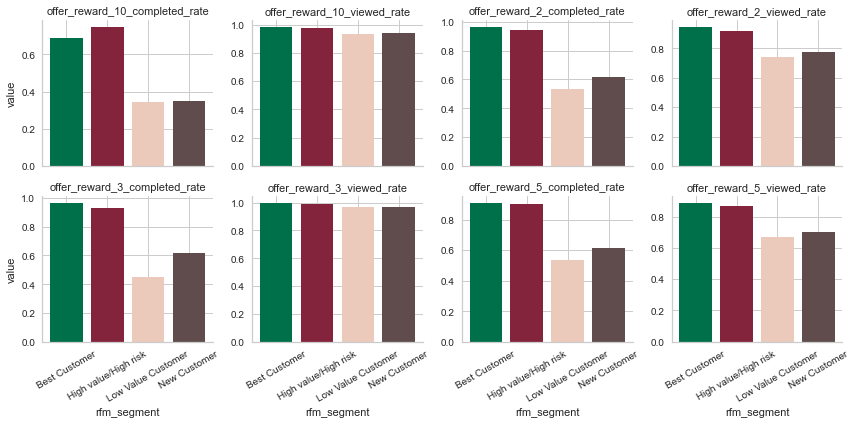

In [124]:
offer_reward =  rfm_analysis[['customer_id','offer_reward_2_viewed_rate','offer_reward_2_completed_rate',
 'offer_reward_3_viewed_rate','offer_reward_3_completed_rate','offer_reward_5_viewed_rate',
 'offer_reward_5_completed_rate','offer_reward_10_viewed_rate','offer_reward_10_completed_rate']]

df = plot_data(offer_reward ,rfm_analysis,   groupby = 'rfm_segment',palette =starbucks_r,col_wrap=4,height=3,label_rotation =30)


<AxesSubplot:>

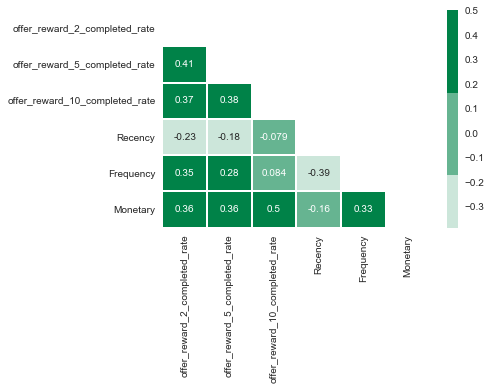

In [125]:
#Correlation plot between the reward completion rate and Recency, Frequency and Monitary values

offer_overall = rfm_analysis[['customer_id','offer_reward_2_completed_rate','offer_reward_5_completed_rate',
                              'offer_reward_10_completed_rate','Recency','Frequency','Monetary']]

sns.heatmap(offer_overall.corr(), annot=True, mask = np.triu(offer_overall.corr()), linewidths=1, 
                 center=0, cmap = starbucks_d)

#### (e). Offer Channel- Mobile, Social and Web

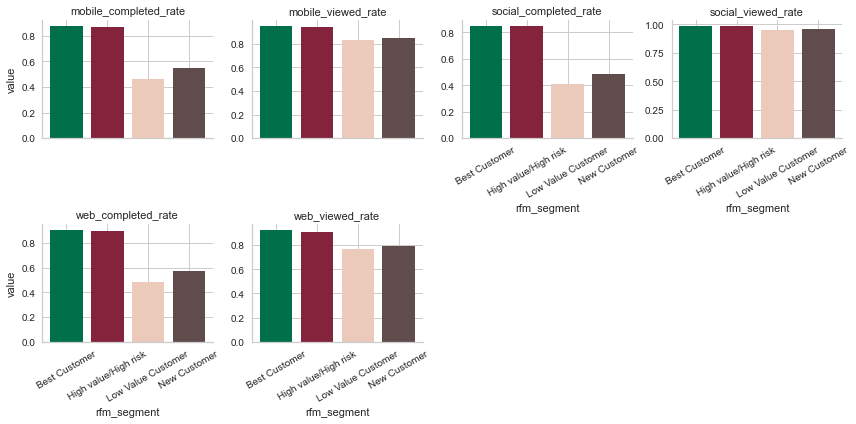

In [126]:
channel_completed =  rfm_analysis[['customer_id', 'mobile_completed_rate', 'social_completed_rate',
 'web_completed_rate','mobile_viewed_rate','social_viewed_rate', 'web_viewed_rate']]
df = plot_data(channel_completed ,rfm_analysis,  groupby = 'rfm_segment',palette =starbucks_r,col_wrap=4,height=3,label_rotation =30)

<AxesSubplot:>

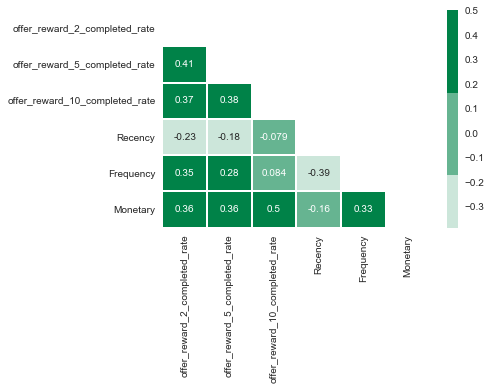

In [127]:
sns.heatmap(offer_overall.corr(), annot=True, mask = np.triu(offer_overall.corr()), linewidths=1, 
                 center=0, cmap = starbucks_d)

## RFM Segment Analysis:

Summary of the finding:



### RFM Segment 1: Best Customer

Frequent customers with heavy spending, and has made purchases recently.

**Customer profile**: 
* Gender, Age and Income distribution in this segment are similar to their distribution in overall sample. 
* Slightly lesser avg income than other segments. 
* Most  joined the app in the year 2016 and 2017. Also has the most no of customers joined between 2013-2015.
* Highest proportion of GenZ and Millennials are from this segment.

**Offer Performance**:
* Overall, offers work best with this group. Overall they have high view rate and completion rate across all offer categories, difficulty, duration and reward.



### RFM Segment 2: High value/High risk customers

Frequent customers with heavy spending. But it has been considerabe time since their last transaction. 

**Customer profile**: 
* Age and Income distribution in this segment are similar to their distribution in overall sample. 
* Almost equal No of Male and Females. Also, has highest proportion on Females and 'Others' compared to other segments. 
* The Avg age is comparable to other segments, however this segment has the highest proportion of GenXers and least proportion of GenZ customers. 
* Highest average income compared to other segments. Also, has the highest proportion of those who ear above 75k+ and the least proportion who earn under 50k. 
* Most  joined the app in the year 2016 and 2017. Also has the most no of customers joined between 2016.!


**Offer Performance**:
* Overall, offers show good performance and nearly comparable to 'Best Customers' segment.  

* However, they seem to show a slightly better performance compared to 'best Customer' segment for BOGO offers, offer difficulty 10, offer duration 5 and offer reward 10.


### RFM Segment 3: Lost Customer

Least frequent shoppers who spent the least, and have made no recent purchases.

**Customer profile**: 
* Gender, Age and Income distribution in this segment are similar to their distribution in overall sample. 
* This segment has a considerably higher proportion of Male and lower proportion of Females compared to the overall sample. 
* Has among the highest proportion of Boomers and Matures. 
* Surprisingly, a high proportion of high income customers belong to this segment. 
* Most joined the app 2017-2018. Also, has the least proportion of those who joined between 2013-2016.

**Offer Performance**:
* As expected, they perform poorer across all offer categories. 
* The customers in this segment seem to be viewing most of the offers sent. However, the offer conversion rate are far lower.


### RFM Segment 4: New customers

Recent shoppers with a low frequency of purchases and transaction amounts.

**Customer profile**: 
* Gender, Age and Income distribution in this segment are similar to their distribution in overall sample. 
* This segment has the highest proportion of Male and lowest proportion of Females compared to the overall sample. 
* Has highest proportion of those earning less than 50k. 
* Most joined the app 2017-2018. 

**Offer Performance**:
* Since they are new customers, they show relatively low offer performance. However they consistently perform better than Low value segment.


# (B). Customer Segmentation: Custer Analysis

## I. Modeling

In [128]:
# Remove 
col_1 = rfm_analysis.iloc[:,11:20].columns
col_1 = col_1.tolist()
col_2 =  rfm_analysis.iloc[:,-9:-4].columns
col_2 = col_2.tolist()

customer_segmentation = rfm_analysis.drop(columns = col_1)
customer_segmentation = customer_segmentation.drop(columns = col_2)
customer_segmentation = customer_segmentation.drop(columns = ['customer_id', 'gender', 'age_group',
       'customer_income_range', 'became_member_on', 'membership_year','High value/High risk',
                                                              'New Customer','Best Customer','Low Value Customer'])

In [129]:
customer_segmentation

,age,customer_income,F,M,O,2013,2014,2015,2016,2017,...,social_viewed_rate,social_completed_rate,web_received_count,web_viewed_count,web_completed_count,web_viewed_rate,web_completed_rate,Recency,Frequency,Monetary
0,55,112000.0,1,0,0,0,0,0,0,1,...,NaN,NaN,1.0,1.0,1.0,1.0,1.000000,7,3,77.01
1,75,100000.0,1,0,0,0,0,0,0,1,...,1.0,1.0,2.0,2.0,2.0,1.0,1.000000,7,7,159.27
2,68,70000.0,0,1,0,0,0,0,0,0,...,1.0,1.0,3.0,3.0,2.0,1.0,0.666667,8,3,57.73
3,65,53000.0,0,1,0,0,0,0,0,0,...,1.0,1.0,6.0,6.0,5.0,1.0,0.833333,4,3,36.43
4,58,51000.0,0,1,0,0,0,0,0,1,...,1.0,0.5,2.0,2.0,1.0,1.0,0.500000,6,4,15.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14429,45,54000.0,1,0,0,0,0,0,0,0,...,1.0,0.0,2.0,2.0,0.0,1.0,0.000000,1,7,20.03
14430,61,72000.0,0,1,0,0,0,0,0,0,...,NaN,NaN,1.0,1.0,1.0,1.0,1.000000,2,7,25.97
14431,49,73000.0,0,1,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,8,39.74
14432,83,50000.0,1,0,0,0,0,0,1,0,...,1.0,1.0,2.0,2.0,2.0,1.0,1.000000,1,14,189.67


In [130]:
customer_segmentation.fillna(0, inplace=True)

In [131]:
col_del = customer_segmentation.iloc[:,30:81].columns.tolist()

In [132]:
customer_segmentation = customer_segmentation.drop(columns = col_del)
customer_segmentation

,age,customer_income,F,M,O,2013,2014,2015,2016,2017,...,social_viewed_rate,social_completed_rate,web_received_count,web_viewed_count,web_completed_count,web_viewed_rate,web_completed_rate,Recency,Frequency,Monetary
0,55,112000.0,1,0,0,0,0,0,0,1,...,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,7,3,77.01
1,75,100000.0,1,0,0,0,0,0,0,1,...,1.0,1.0,2.0,2.0,2.0,1.0,1.000000,7,7,159.27
2,68,70000.0,0,1,0,0,0,0,0,0,...,1.0,1.0,3.0,3.0,2.0,1.0,0.666667,8,3,57.73
3,65,53000.0,0,1,0,0,0,0,0,0,...,1.0,1.0,6.0,6.0,5.0,1.0,0.833333,4,3,36.43
4,58,51000.0,0,1,0,0,0,0,0,1,...,1.0,0.5,2.0,2.0,1.0,1.0,0.500000,6,4,15.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14429,45,54000.0,1,0,0,0,0,0,0,0,...,1.0,0.0,2.0,2.0,0.0,1.0,0.000000,1,7,20.03
14430,61,72000.0,0,1,0,0,0,0,0,0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.000000,2,7,25.97
14431,49,73000.0,0,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,8,39.74
14432,83,50000.0,1,0,0,0,0,0,1,0,...,1.0,1.0,2.0,2.0,2.0,1.0,1.000000,1,14,189.67


In [133]:
customer_segmentation.iloc[:,0:81]

,age,customer_income,F,M,O,2013,2014,2015,2016,2017,...,offer_reward_2_viewed_count,offer_reward_2_completed_count,offer_reward_2_viewed_rate,offer_reward_2_completed_rate,offer_reward_10_received_count,offer_reward_10_viewed_count,offer_reward_10_completed_count,offer_reward_10_viewed_rate,offer_reward_10_completed_rate,offer_reward_3_received_count
0,55,112000.0,1,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,75,100000.0,1,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
2,68,70000.0,0,1,0,0,0,0,0,0,...,2.0,1.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
3,65,53000.0,0,1,0,0,0,0,0,0,...,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,58,51000.0,0,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14429,45,54000.0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14430,61,72000.0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14431,49,73000.0,0,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14432,83,50000.0,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0


### Dimensionality Reduction with PCA

In [134]:
from sklearn.preprocessing import StandardScaler
std_customer = StandardScaler().fit_transform(customer_segmentation) # normalizing the data 

In [135]:
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
principalComponents = pca.fit_transform(std_customer)


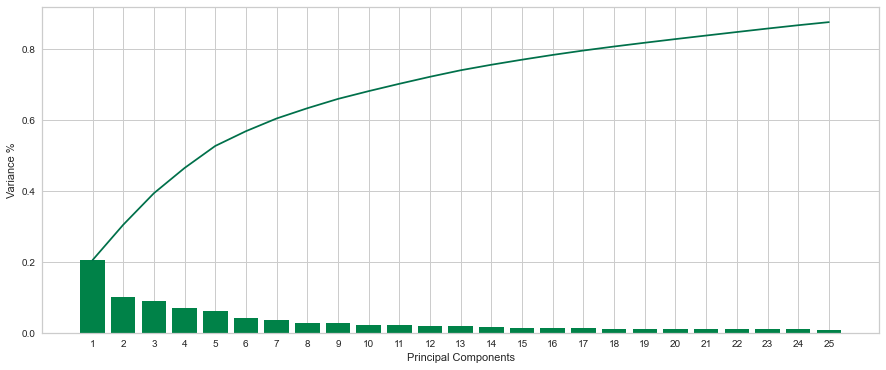

In [136]:
# Plotting the variances for each PC
cumvals = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(15,6))
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color= ["#008248"])
plt.plot(PC, cumvals)
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)

# Putting components in a dataframe for later
PCA_components = pd.DataFrame(principalComponents)

In [137]:
# PCA with 80% of the variance explained by components

cumvals = np.cumsum(pca.explained_variance_ratio_)
num_comp = len(cumvals[cumvals <= 0.80])

pca = PCA(num_comp).fit(std_customer)
customer_pca = pca.transform(std_customer)
customer_pca = pd.DataFrame(customer_pca)

np.cumsum(pca.explained_variance_ratio_)

array([0.20465747, 0.30425714, 0.39322067, 0.4643664 , 0.52647235,
       0.5681118 , 0.6039421 , 0.63278265, 0.65909568, 0.68100125,
       0.70166889, 0.721446  , 0.73979648, 0.75530636, 0.76956619,
       0.78300645, 0.7953133 ])

Most of the variance is put in the first component. Reamaining is left for the 2nd component and , then component 3, etc.

## (A). K-means Cluster Analysis

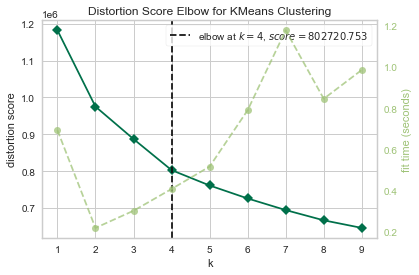

In [138]:
#Use elbow method to determine the optimum number of clusters needed for Method2
kelbow_visualizer(KMeans(), customer_pca, k=(1,10));

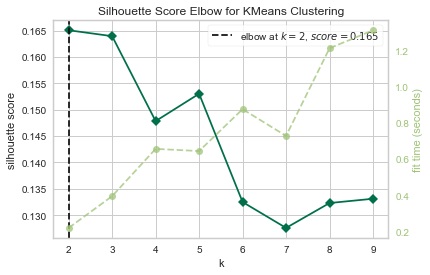

In [139]:
# Finding Silhouette score to check uptimum no of cluster
kelbow_visualizer(KMeans(), customer_pca, k=(2,10), metric='silhouette');

Lookng at the WCSS plot, 'Elbow' at k=4, thus the optimal number of cluster is 4.

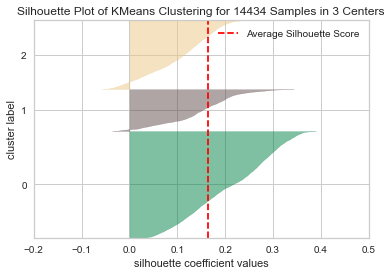

dict_keys(['ax', 'colors', 'estimator', 'is_fitted']) 


dict_keys(['ax', 'colors', 'estimator', 'is_fitted']) 




SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 14434 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors=['#008248', '#604c4c', '#eac784', '#f0cddb',
                             '#6B9997'],
                     estimator=KMeans(n_clusters=3, random_state=42))

In [142]:
# Use the quick method and immediately show the figure
silhouette_visualizer(KMeans(3, random_state=42), customer_pca, colors=starbucks)

In [145]:
model = KMeans(n_clusters=3, random_state=45).fit(customer_pca)
kmeans_clusters = model.predict(customer_pca)

In [146]:
kmeans_clusters

array([2, 0, 0, ..., 2, 0, 1])

In [147]:
customer_pca_cluster = customer_pca.copy()
customer_pca_cluster['cluster'] = kmeans_clusters
#sns.pairplot(rfm_pca_cluster, hue='cluster')

In [148]:
segment_analysis = rfm_analysis.copy()
segment_analysis['cluster'] = customer_pca_cluster['cluster']

In [149]:
#Create dummy variables for the Customer Segments
segment_dummies = pd.get_dummies(segment_analysis['cluster'], prefix = 'cluster')
segment_analysis = segment_analysis.join(segment_dummies)

In [150]:
segment_analysis['cluster'].value_counts()

2    7094
0    4559
1    2781
Name: cluster, dtype: int64

In [151]:
cluster = segment_analysis[['customer_id','cluster_0', 'cluster_1','cluster_2']]

## III.  Visualizatoon and Analysis


### Segmentation: Demographics analysis

### 1. Gender

In [152]:
starbucks_s = ["#f0d4dc","#00754a","#84233c","#e44c2c","#a17700","#84233c" ,"#604c4c","#ebcabc","#e44c2c","#562f1e","#f0cdbc"]

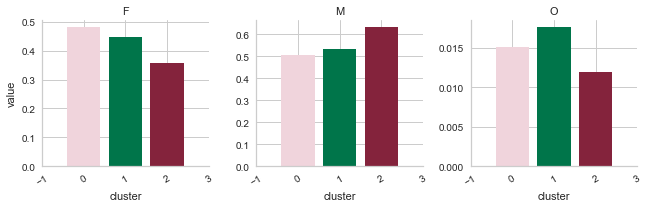

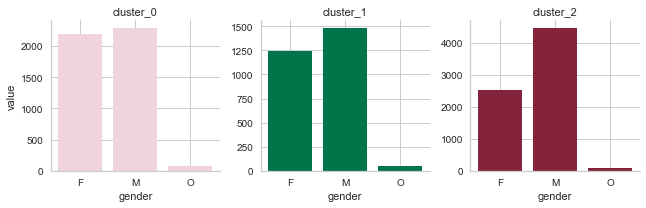

In [153]:


rfm_gender = segment_analysis[['customer_id','M','F',"O"]]
df = plot_data(rfm_gender,segment_analysis,  groupby = 'cluster',palette =starbucks_s,col_wrap=5,height=3,label_rotation =30)
df = plot_data_sum(cluster,segment_analysis,  groupby = 'gender',palette =starbucks_s,col_wrap=4,height=3,label_rotation =0)


### 2. Age

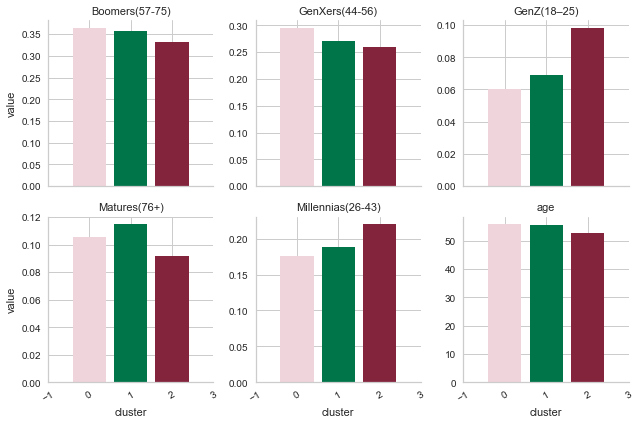

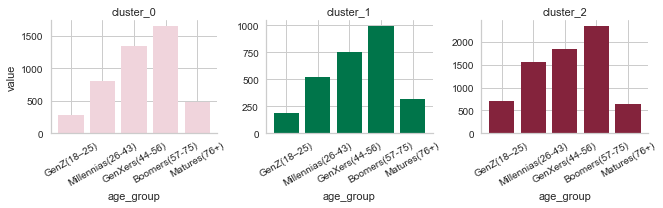

In [154]:
df = plot_data(rfm_age,segment_analysis,  groupby = 'cluster',palette =starbucks_s,col_wrap=3,height=3,label_rotation =30)
df = plot_data_sum(cluster,segment_analysis,  groupby = 'age_group',palette =starbucks_s,col_wrap=25,height=3,label_rotation =30)


### 3. Customer Income

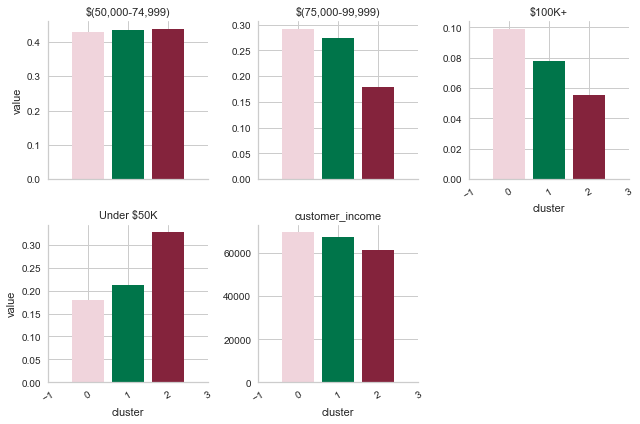

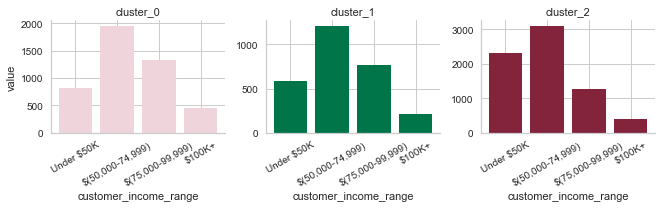

In [161]:
rfm_income_range_1 = segment_analysis[['customer_id','customer_income', 'Under $50K','$(50,000-74,999)','$(75,000-99,999)', '$100K+']]
df = plot_data(rfm_income_range_1,segment_analysis,  groupby = 'cluster',palette =starbucks_s,col_wrap=3,height=3,label_rotation =30)
df = plot_data_sum(cluster,segment_analysis,  groupby = 'customer_income_range',palette =starbucks_s,col_wrap=25,height=3,label_rotation =30)


### 4. Year joined

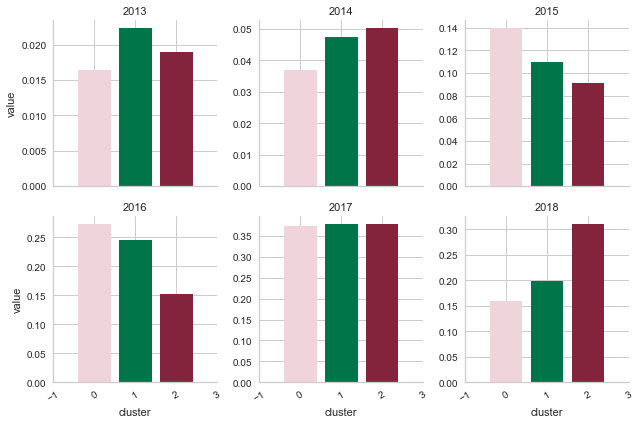

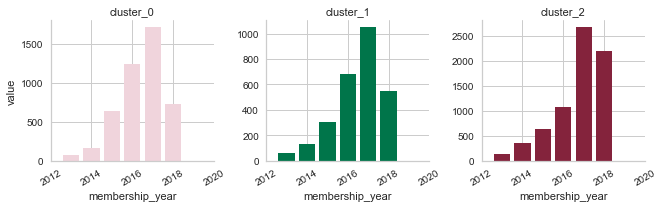

In [155]:
rfm_year = segment_analysis[['customer_id',2013, 2014, 2015, 2016, 2017, 2018]]

df = plot_data(rfm_year,segment_analysis,  groupby = 'cluster',palette =starbucks_s,col_wrap=3,height=3,label_rotation =30)

df = plot_data_sum(cluster,segment_analysis,  groupby = 'membership_year',palette =starbucks_s,col_wrap=25,height=3,label_rotation =30)


### Segmentation: Offer Analysis

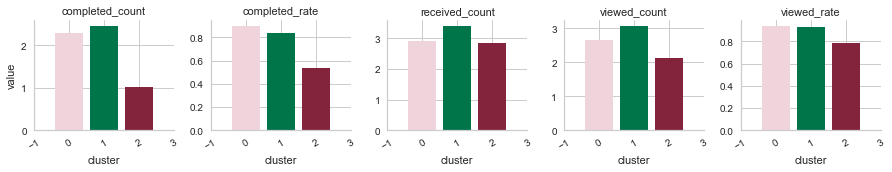

In [161]:
#All offers
offer_overall = segment_analysis[['customer_id','viewed_count','received_count','completed_count','viewed_rate','completed_rate']]

df = plot_data(offer_overall,segment_analysis,  groupby = 'cluster',palette =starbucks_s,col_wrap=5,height=2.5,label_rotation =30)

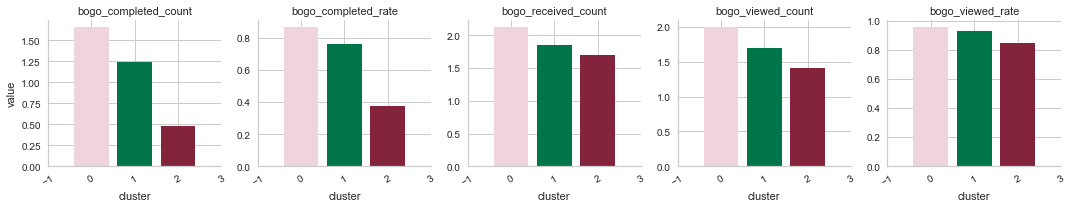

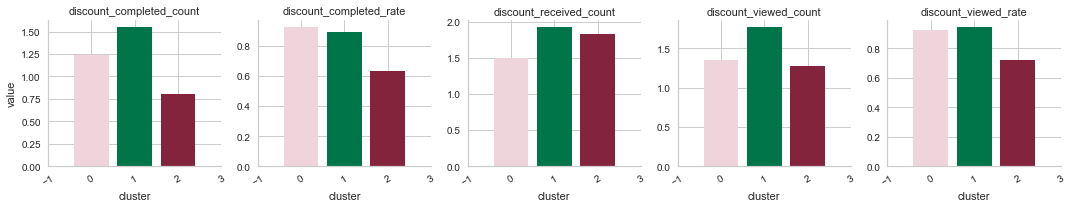

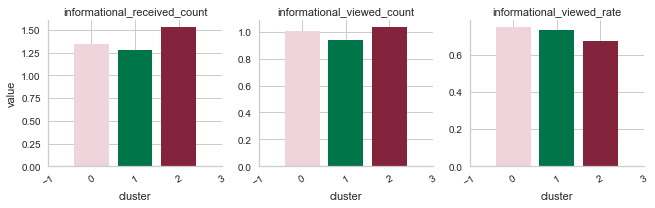

In [165]:
#Offer type: BOGO
offer_bogo = segment_analysis[['customer_id','bogo_received_count', 'bogo_viewed_count','bogo_completed_count','bogo_viewed_rate','bogo_completed_rate']]
df = plot_data(offer_bogo,segment_analysis,  groupby = 'cluster',palette =starbucks_s,col_wrap=5,height=3,label_rotation =30)

#Offer Type: Discount
offer_discount = segment_analysis[['customer_id','discount_received_count','discount_viewed_count','discount_completed_count','discount_viewed_rate','discount_completed_rate']]
df = plot_data( offer_discount,segment_analysis,  groupby = 'cluster',palette =starbucks_s,col_wrap=5,height=3,label_rotation =30)

#Offer Type: Informationa.
offer_informational = segment_analysis[['customer_id','informational_received_count','informational_viewed_count','informational_viewed_rate']]
df = plot_data(offer_informational,segment_analysis,  groupby = 'cluster',palette =starbucks_s,col_wrap=5,height=3,label_rotation =30)

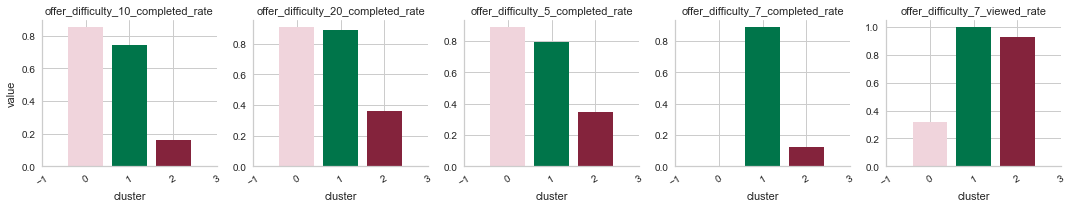

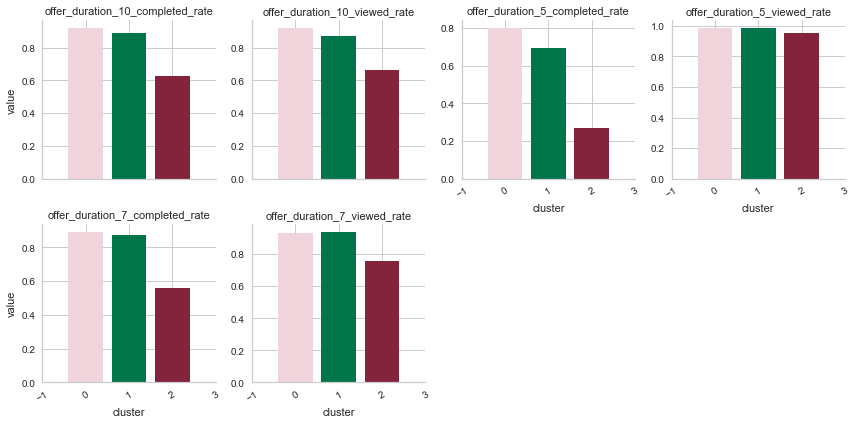

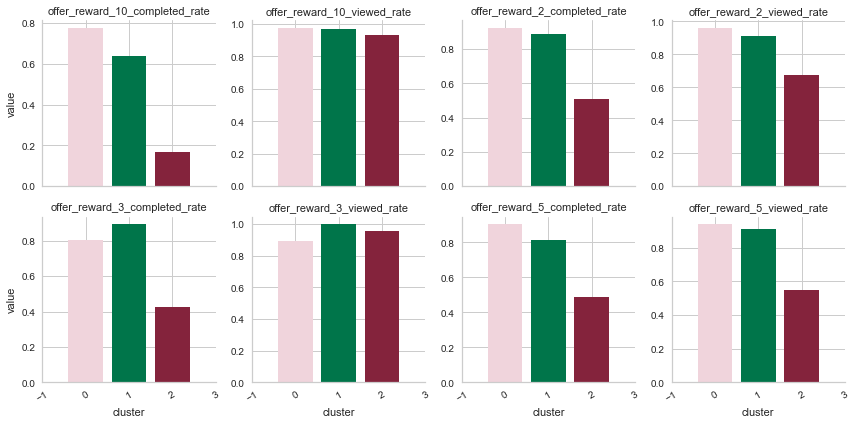

In [166]:
#Offer Difficulty
offer_difficulty =  segment_analysis[['customer_id','offer_difficulty_5_completed_rate',
 'offer_difficulty_20_completed_rate','offer_difficulty_10_completed_rate', 'offer_difficulty_7_viewed_rate','offer_difficulty_7_completed_rate']]
df = plot_data(offer_difficulty ,segment_analysis,   groupby = 'cluster',palette =starbucks_s,col_wrap=5,height=3,label_rotation =30)

#df = plot_data(offer_difficulty ,segment_analysis,   groupby = 'cluster_h',palette =4,col_wrap=5,height=3,label_rotation =30)

#Offer Duration
offer_duration =  segment_analysis[['customer_id', 'offer_duration_7_viewed_rate', 'offer_duration_7_completed_rate',
 'offer_duration_10_viewed_rate', 'offer_duration_10_completed_rate','offer_duration_5_viewed_rate',
 'offer_duration_5_completed_rate']]
df = plot_data(offer_duration ,segment_analysis,  groupby = 'cluster',palette =starbucks_s,col_wrap=4,height=3,label_rotation =30)



#Offer Reward
offer_reward =  segment_analysis[['customer_id','offer_reward_2_viewed_rate','offer_reward_2_completed_rate',
 'offer_reward_3_viewed_rate','offer_reward_3_completed_rate','offer_reward_5_viewed_rate',
 'offer_reward_5_completed_rate','offer_reward_10_viewed_rate','offer_reward_10_completed_rate']]
df = plot_data(offer_reward ,segment_analysis,   groupby = 'cluster',palette =starbucks_s,col_wrap=4,height=3,label_rotation =30)


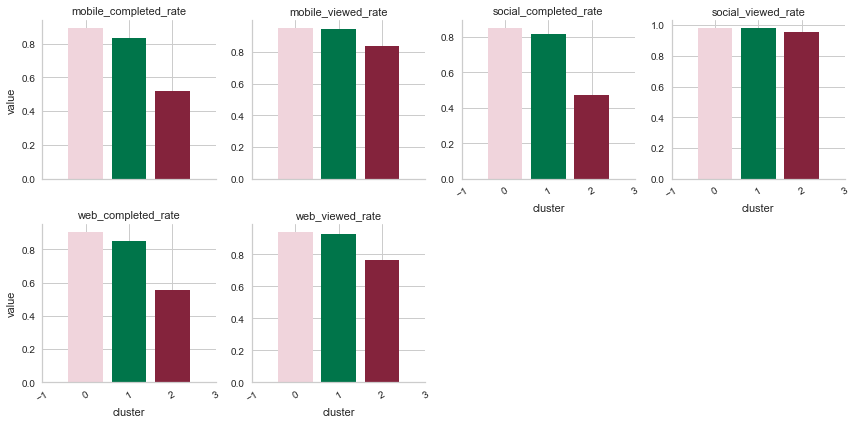

In [168]:
#Channel used

channel_completed =  segment_analysis[['customer_id', 'mobile_completed_rate','mobile_completed_rate', 'social_completed_rate',
 'web_completed_rate','mobile_viewed_rate','social_viewed_rate', 'web_viewed_rate']]
df = plot_data(channel_completed ,segment_analysis,  groupby = 'cluster',palette =starbucks_s,col_wrap=4,height=3,label_rotation =30)

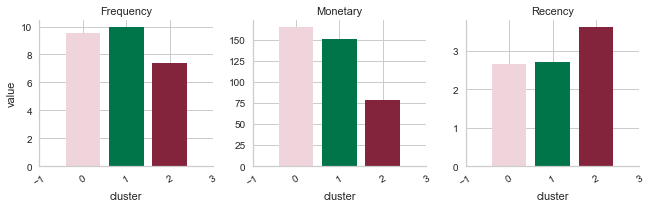

In [169]:
#Visualize the mean Frequency, Monetary, and Recency value across each RFM segments

rfm_d= segment_analysis[['customer_id','Recency','Frequency','Monetary']]
df = plot_data(rfm_d,segment_analysis,  groupby = 'cluster',palette =starbucks_s,col_wrap=5,height=3,label_rotation =30)

<AxesSubplot:>

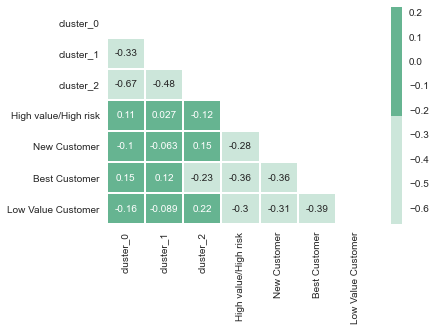

In [171]:
#Correlation between RFM segments and Kmeans segments. 
rfm_d= segment_analysis[['customer_id','cluster_0', 'cluster_1', 'cluster_2',
                     'High value/High risk','New Customer','Best Customer','Low Value Customer' ]]
sns.heatmap(rfm_d.corr(), annot=True, mask = np.triu(rfm_d.corr()), linewidths=1, 
                 center=0, cmap = starbucks_d)

## (B). Hierarchical clustering

In [1]:

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch


In [ ]:
dendrogram = sch.dendrogram(sch.linkage(customer_pca,method = 'ward'))

In [2]:
kelbow_visualizer(AgglomerativeClustering(), customer_pca, k=(1,14));

NameError: name 'kelbow_visualizer' is not defined

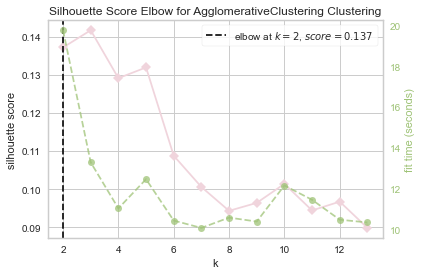

In [184]:
kelbow_visualizer(AgglomerativeClustering(), customer_pca, k=(2,14), metric='silhouette');

In [185]:
hc = AgglomerativeClustering(n_clusters = 4 , affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(customer_pca)

customer_pca_cluster = customer_pca.copy()
customer_pca_cluster['cluster_h'] = y_hc

customer_pca_cluster['cluster_h']

segment_analysis['cluster_h'] = customer_pca_cluster['cluster_h']
segment_analysis['cluster_h'].value_counts()

0    4300
3    4276
1    3540
2    2318
Name: cluster_h, dtype: int64

In [186]:
#Create dummy variables for the Customer Segments
segment_dummies_h = pd.get_dummies(segment_analysis['cluster_h'], prefix = 'cluster_h')
segment_analysis = segment_analysis.join(segment_dummies_h)

In [204]:
cluster_h = segment_analysis[['customer_id','cluster_h_0', 'cluster_h_1','cluster_h_2', 'cluster_h_3']]

In [203]:
segment_analysis

,customer_id,gender,age,age_group,customer_income,customer_income_range,became_member_on,membership_year,F,M,...,New Customer,cluster,cluster_0,cluster_1,cluster_2,cluster_h,cluster_h_0,cluster_h_1,cluster_h_2,cluster_h_3
0,0610b486422d4921ae7d2bf64640c50b,F,55,GenXers(44-56),112000.0,$100K+,2017-07-15,2017,1,0,...,0,2,0,0,1,0,1,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,Boomers(57-75),100000.0,$100K+,2017-05-09,2017,1,0,...,0,0,1,0,0,0,1,0,0,0
2,e2127556f4f64592b11af22de27a7932,M,68,Boomers(57-75),70000.0,"$(50,000-74,999)",2018-04-26,2018,0,1,...,0,0,1,0,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,M,65,Boomers(57-75),53000.0,"$(50,000-74,999)",2018-02-09,2018,0,1,...,0,0,1,0,0,0,1,0,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,M,58,Boomers(57-75),51000.0,"$(50,000-74,999)",2017-11-11,2017,0,1,...,0,2,0,0,1,3,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14429,6d5f3a774f3d4714ab0c092238f3a1d7,F,45,GenXers(44-56),54000.0,"$(50,000-74,999)",2018-06-04,2018,1,0,...,1,2,0,0,1,1,0,1,0,0
14430,2cb4f97358b841b9a9773a7aa05a9d77,M,61,Boomers(57-75),72000.0,"$(50,000-74,999)",2018-07-13,2018,0,1,...,1,2,0,0,1,0,1,0,0,0
14431,01d26f638c274aa0b965d24cefe3183f,M,49,GenXers(44-56),73000.0,"$(50,000-74,999)",2017-01-26,2017,0,1,...,1,2,0,0,1,1,0,1,0,0
14432,9dc1421481194dcd9400aec7c9ae6366,F,83,Matures(76+),50000.0,"$(50,000-74,999)",2016-03-07,2016,1,0,...,0,0,1,0,0,0,1,0,0,0


### 1. Gender

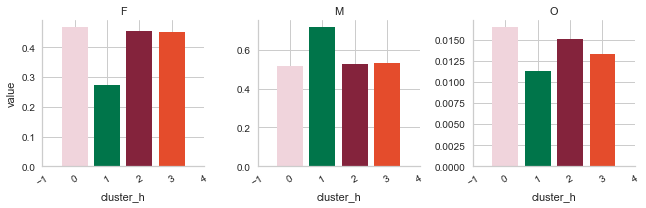

In [188]:
rfm_gender = segment_analysis[['customer_id','M','F',"O"]]
df = plot_data(rfm_gender,segment_analysis,  groupby = 'cluster_h',palette = starbucks_s,col_wrap=5,height=3,label_rotation =30)

### 2. Age

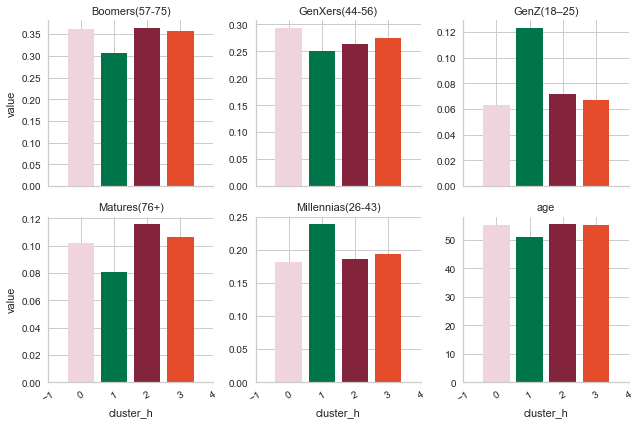

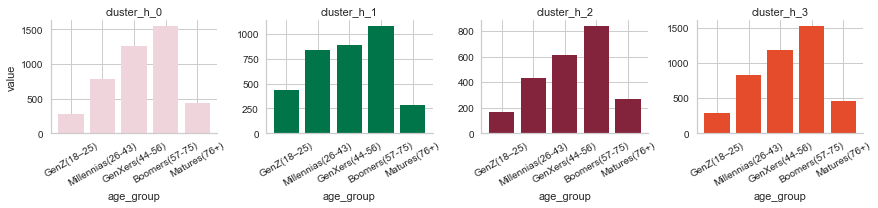

In [205]:


df = plot_data(rfm_age,segment_analysis,  groupby = 'cluster_h',palette =starbucks_s,col_wrap=3,height=3,label_rotation =30)

df = plot_data_sum(cluster_h,segment_analysis,  groupby = 'age_group',palette =starbucks_s,col_wrap=25,height=3,label_rotation =30)


### 3. Customer Income

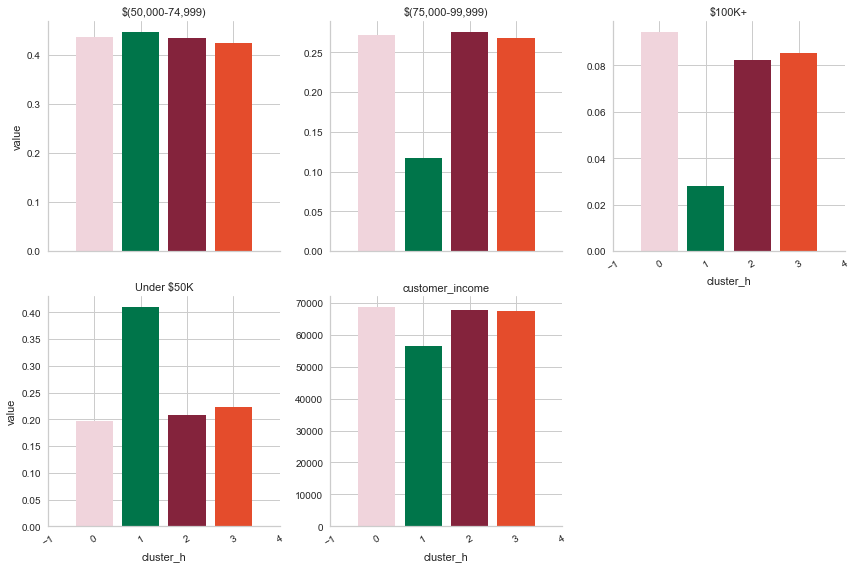

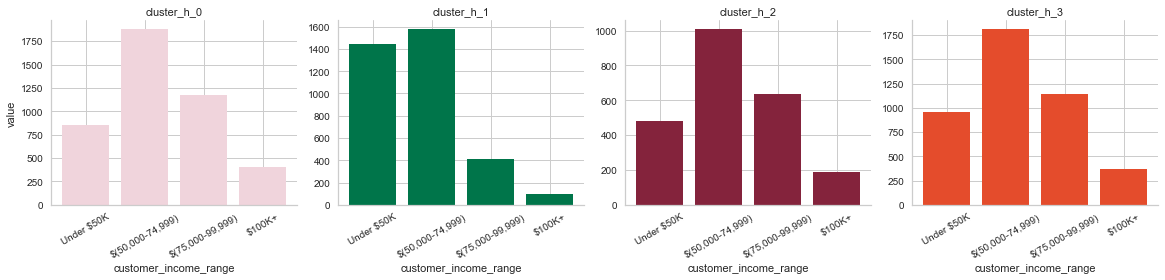

In [208]:
rfm_income_range_1 = segment_analysis[['customer_id','customer_income', 'Under $50K','$(50,000-74,999)','$(75,000-99,999)', '$100K+']]
df = plot_data(rfm_income_range_1,segment_analysis,  groupby = 'cluster_h',palette =starbucks_s,col_wrap=3,height=4,label_rotation =30)
df = plot_data_sum(cluster_h,segment_analysis,  groupby = 'customer_income_range',palette =starbucks_s,col_wrap=25,height=4,label_rotation =30)



### 4. Year joined

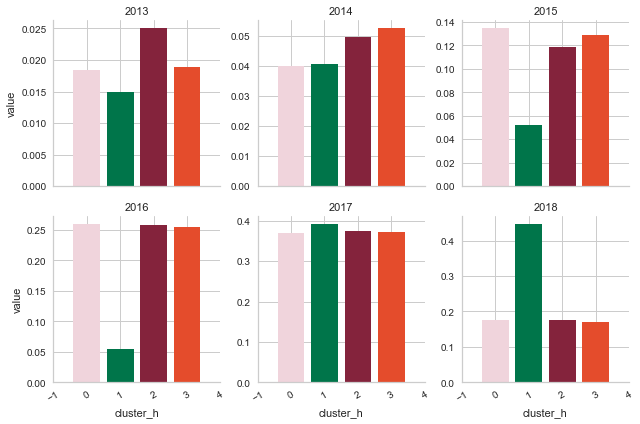

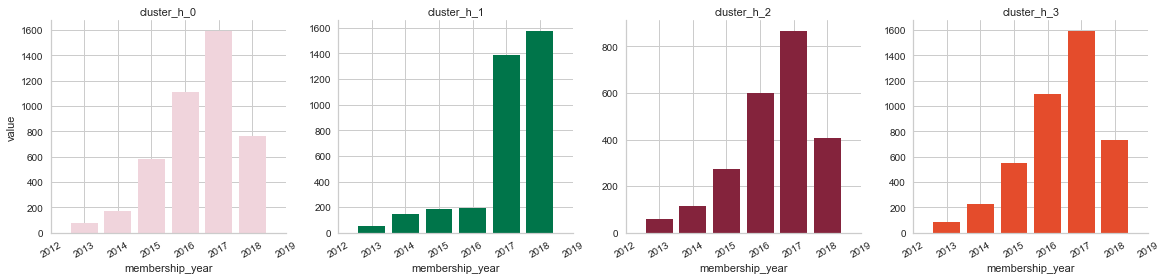

In [209]:
rfm_year = segment_analysis[['customer_id',2013, 2014, 2015, 2016, 2017, 2018]]

df = plot_data(rfm_year,segment_analysis,  groupby = 'cluster_h',palette =starbucks_s,col_wrap=3,height=3,label_rotation =30)

df = plot_data_sum(cluster_h,segment_analysis,  groupby = 'membership_year',palette =starbucks_s,col_wrap=25,height=4,label_rotation =30)


## Segmentation: Offer Analysis

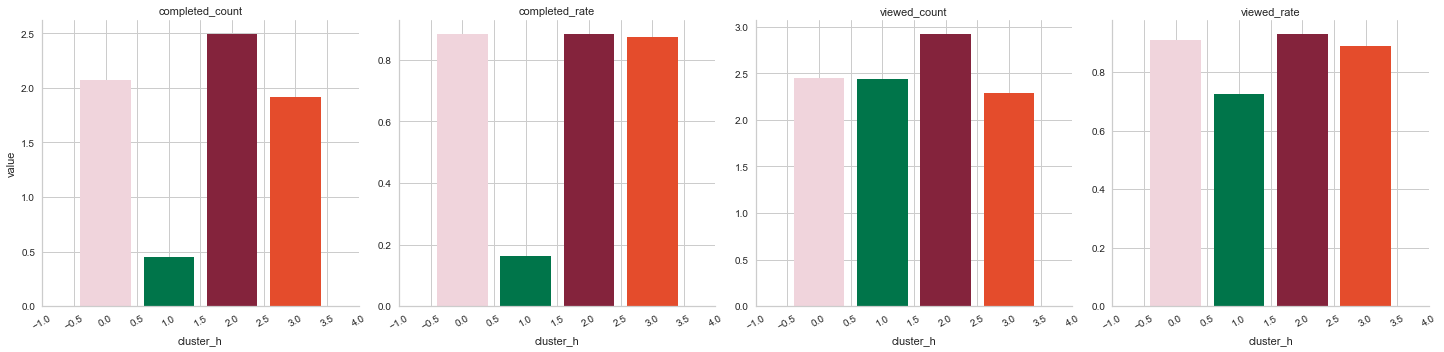

In [194]:
#All offers
offer_overall = segment_analysis[['customer_id','viewed_count','completed_count','viewed_rate','completed_rate']]

df = plot_data(offer_overall,segment_analysis,  groupby = 'cluster_h',palette =starbucks_s,col_wrap=5,height=5,label_rotation =30)

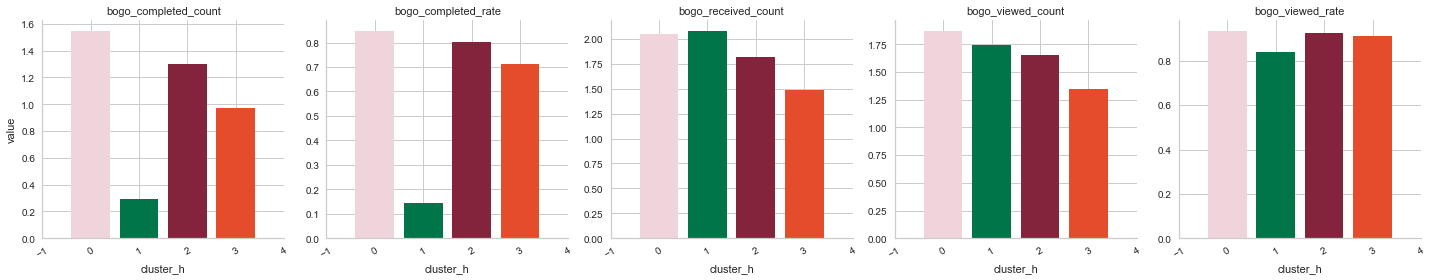

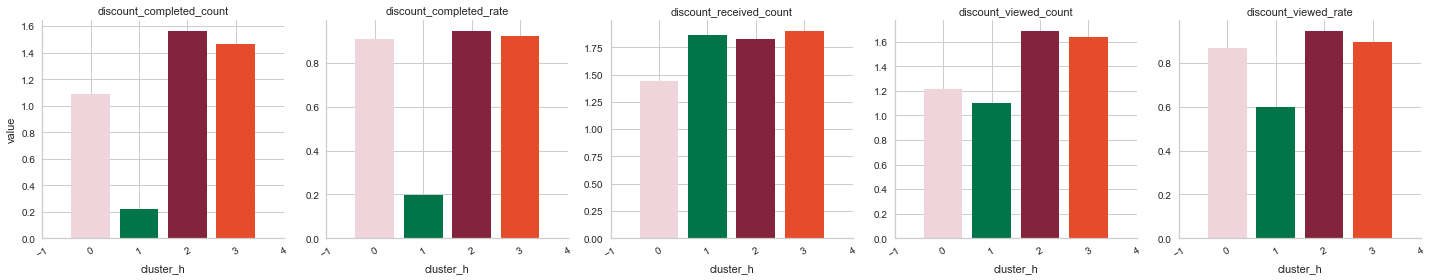

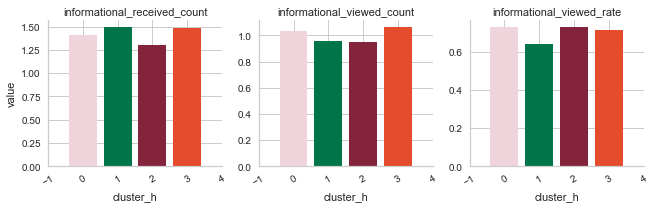

In [195]:
#Offer type: BOGO
offer_bogo = segment_analysis[['customer_id','bogo_received_count', 'bogo_viewed_count','bogo_completed_count','bogo_viewed_rate','bogo_completed_rate']]
df = plot_data(offer_bogo,segment_analysis,  groupby = 'cluster_h',palette =starbucks_s,col_wrap=5,height=4,label_rotation =30)

#Offer Type: Discount
offer_discount = segment_analysis[['customer_id','discount_received_count','discount_viewed_count','discount_completed_count','discount_viewed_rate','discount_completed_rate']]
df = plot_data( offer_discount,segment_analysis,  groupby = 'cluster_h',palette =starbucks_s,col_wrap=5,height=4,label_rotation =30)

#Offer Type: Informationa.
offer_informational = segment_analysis[['customer_id','informational_received_count','informational_viewed_count','informational_viewed_rate']]
df = plot_data(offer_informational,segment_analysis,  groupby = 'cluster_h',palette =starbucks_s,col_wrap=5,height=3,label_rotation =30)

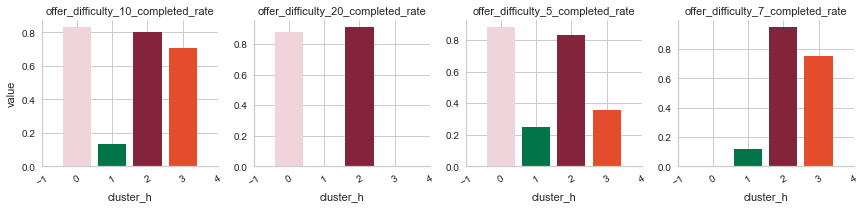

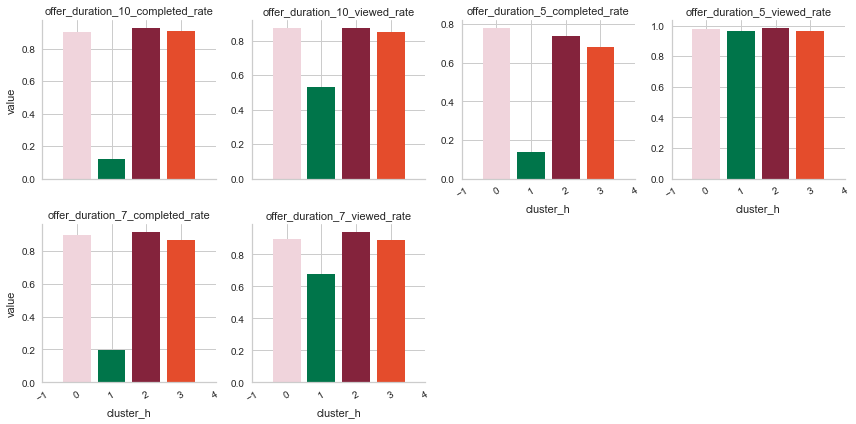

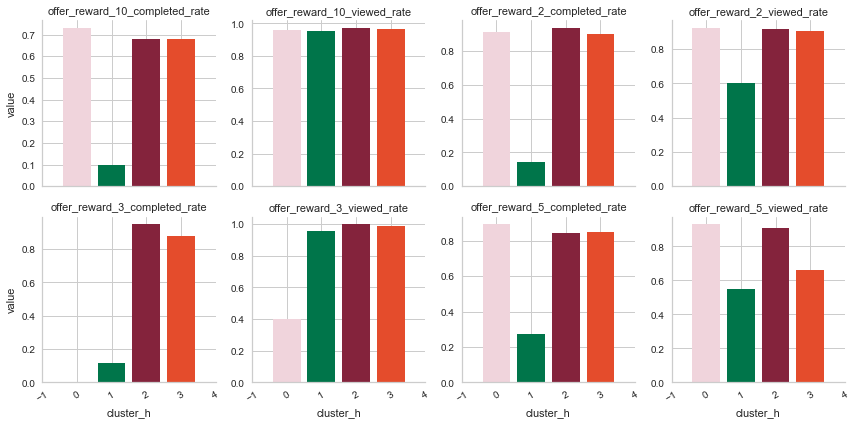

In [196]:
#Offer Difficulty
offer_difficulty =  segment_analysis[['customer_id','offer_difficulty_5_completed_rate',
 'offer_difficulty_20_completed_rate','offer_difficulty_10_completed_rate', 'offer_difficulty_7_completed_rate']]
df = plot_data(offer_difficulty ,segment_analysis,   groupby = 'cluster_h',palette =starbucks_s,col_wrap=5,height=3,label_rotation =30)

#df = plot_data(offer_difficulty ,segment_analysis,   groupby = 'cluster_h',palette =4,col_wrap=5,height=3,label_rotation =30)

#Offer Duration
offer_duration =  segment_analysis[['customer_id', 'offer_duration_7_viewed_rate', 'offer_duration_7_completed_rate',
 'offer_duration_10_viewed_rate', 'offer_duration_10_completed_rate','offer_duration_5_viewed_rate',
 'offer_duration_5_completed_rate']]
df = plot_data(offer_duration ,segment_analysis,  groupby = 'cluster_h',palette =starbucks_s,col_wrap=4,height=3,label_rotation =30)



#Offer Reward
offer_reward =  segment_analysis[['customer_id','offer_reward_2_viewed_rate','offer_reward_2_completed_rate',
 'offer_reward_3_viewed_rate','offer_reward_3_completed_rate','offer_reward_5_viewed_rate',
 'offer_reward_5_completed_rate','offer_reward_10_viewed_rate','offer_reward_10_completed_rate']]
df = plot_data(offer_reward ,segment_analysis,   groupby = 'cluster_h',palette =starbucks_s,col_wrap=4,height=3,label_rotation =30)


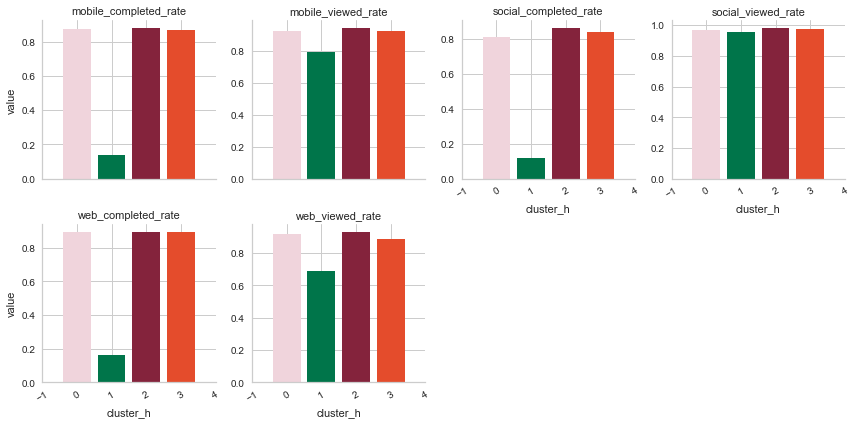

In [197]:
#Channel used

channel_completed =  segment_analysis[['customer_id', 'mobile_completed_rate','mobile_completed_rate', 'social_completed_rate',
 'web_completed_rate','mobile_viewed_rate','social_viewed_rate', 'web_viewed_rate']]
df = plot_data(channel_completed ,segment_analysis,  groupby = 'cluster_h',palette =starbucks_s,col_wrap=4,height=3,label_rotation =30)

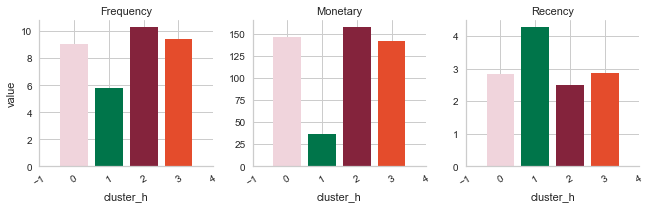

In [198]:
#Visualize the mean Frequency, Monetary, and Recency value across each RFM segments

rfm_d= segment_analysis[['customer_id','Recency','Frequency','Monetary']]
df = plot_data(rfm_d,segment_analysis,  groupby = 'cluster_h',palette =starbucks_s,col_wrap=5,height=3,label_rotation =30)

<AxesSubplot:>

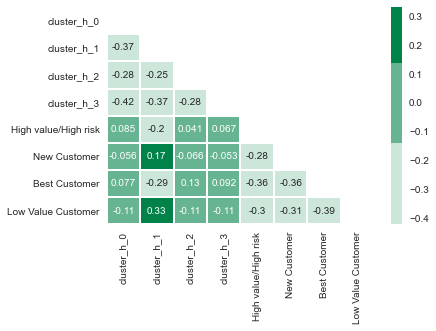

In [199]:
#Correlation between RFM segments and Kmeans segments. 
rfm_d= segment_analysis[['customer_id','cluster_h_0', 'cluster_h_1', 'cluster_h_2','cluster_h_3',
                     'High value/High risk','New Customer','Best Customer','Low Value Customer' ]]
sns.heatmap(rfm_d.corr(), annot=True, mask = np.triu(rfm_d.corr()), linewidths=1, 
                 center=0, cmap = starbucks_d)